Project: HeartTrend: Data-Driven Health Trends and Lifestyle Nudges

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pytz

def parse_ecg_files(files, directory):
    df = pd.DataFrame(columns=['patient', 'recorded_date', 'classification', 'ecg_data'])

    # Specify your local timezone
    local_tz = pytz.timezone('America/Chicago')

    for file in files:
        path = os.path.join(directory, file)
        with open(path, 'r') as f:
            lines = f.readlines()

        # Extract metadata
        patient_name = lines[0].split(',')[1].strip()
        recorded_date = lines[2].split(',')[1].strip()
        classification = lines[3].split(',')[1].strip()

        # ECG values start from line 13 onward
        ecg_values = [float(line.strip().replace(',', '.')) for line in lines[13:] if line.strip() != '']

        # Convert the 'Recorded Date' to datetime format with the timezone offset
        recorded_date = pd.to_datetime(recorded_date, errors='coerce')

        # If the recorded_date has no timezone, we assume it's in UTC by default.
        if recorded_date.tzinfo is None:
            recorded_date = recorded_date.tz_localize('UTC')

        # Convert to local timezone (America/Chicago)
        recorded_date = recorded_date.astimezone(local_tz)

        # Add the data to the dataframe
        df = pd.concat([
            df,
            pd.DataFrame([{
                'patient': patient_name,
                'recorded_date': recorded_date,
                'classification': classification,
                'ecg_data': ecg_values
            }])
        ], ignore_index=True)

    return df

# Folder path where the CSV files are stored
folder_path = "./apple_health_export/electrocardiograms"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Parse the ECG files and combine them into a single dataframe
ecg_df = parse_ecg_files(csv_files, folder_path)

# Print the first few rows of the dataframe
print(ecg_df.head())


          patient             recorded_date classification  \
0  Apoorv Mahajan 2022-04-19 15:28:49-05:00   Sinus Rhythm   
1  Apoorv Mahajan 2024-11-11 09:25:25-06:00   Sinus Rhythm   
2  Apoorv Mahajan 2022-03-29 14:02:20-05:00   Sinus Rhythm   
3  Apoorv Mahajan 2022-06-18 11:38:20-05:00   Sinus Rhythm   
4  Apoorv Mahajan 2023-04-08 05:52:12-05:00   Sinus Rhythm   

                                            ecg_data  
0  [43.892, 38.552, 33.429, 28.59, 24.098, 20.01,...  
1  [-69.291, -70.068, -70.645, -70.776, -70.163, ...  
2  [17.491, 18.837, 20.105, 21.295, 22.407, 23.44...  
3  [-5.491, -4.227, -3.096, -2.099, -1.234, -0.50...  
4  [13.586, 15.732, 17.779, 19.718, 21.543, 23.24...  


/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_92245/1490028701.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


In [6]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply the bandpass filter to the ECG data (example values for lowcut and highcut)
fs = 512  # Sampling frequency (Hz)
lowcut = 0.5  # Low cutoff frequency (Hz)
highcut = 50.0  # High cutoff frequency (Hz)

ecg_df['filtered_ecg'] = ecg_df['ecg_data'].apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))

# Print the first few rows to verify
print(ecg_df.head())


          patient             recorded_date classification  \
0  Apoorv Mahajan 2022-04-19 15:28:49-05:00   Sinus Rhythm   
1  Apoorv Mahajan 2024-11-11 09:25:25-06:00   Sinus Rhythm   
2  Apoorv Mahajan 2022-03-29 14:02:20-05:00   Sinus Rhythm   
3  Apoorv Mahajan 2022-06-18 11:38:20-05:00   Sinus Rhythm   
4  Apoorv Mahajan 2023-04-08 05:52:12-05:00   Sinus Rhythm   

                                            ecg_data  \
0  [43.892, 38.552, 33.429, 28.59, 24.098, 20.01,...   
1  [-69.291, -70.068, -70.645, -70.776, -70.163, ...   
2  [17.491, 18.837, 20.105, 21.295, 22.407, 23.44...   
3  [-5.491, -4.227, -3.096, -2.099, -1.234, -0.50...   
4  [13.586, 15.732, 17.779, 19.718, 21.543, 23.24...   

                                        filtered_ecg  
0  [-2.314733098448509, -7.568279352485441, -12.6...  
1  [-105.64812204126169, -106.35557289125946, -10...  
2  [8.305895379305476, 9.661963675346511, 10.9877...  
3  [-5.786916394115328, -4.611702692921732, -3.48...  
4  [2.797912951

In [7]:
from scipy.signal import find_peaks

def detect_r_peaks(filtered_ecg, threshold=0.5):
    # Find peaks with a minimum height threshold
    peaks, _ = find_peaks(filtered_ecg, height=threshold)
    return peaks

# Apply R-peak detection to the filtered ECG data
ecg_df['r_peaks'] = ecg_df['filtered_ecg'].apply(detect_r_peaks)

# Print the first few rows to check the results
print(ecg_df.head())


          patient             recorded_date classification  \
0  Apoorv Mahajan 2022-04-19 15:28:49-05:00   Sinus Rhythm   
1  Apoorv Mahajan 2024-11-11 09:25:25-06:00   Sinus Rhythm   
2  Apoorv Mahajan 2022-03-29 14:02:20-05:00   Sinus Rhythm   
3  Apoorv Mahajan 2022-06-18 11:38:20-05:00   Sinus Rhythm   
4  Apoorv Mahajan 2023-04-08 05:52:12-05:00   Sinus Rhythm   

                                            ecg_data  \
0  [43.892, 38.552, 33.429, 28.59, 24.098, 20.01,...   
1  [-69.291, -70.068, -70.645, -70.776, -70.163, ...   
2  [17.491, 18.837, 20.105, 21.295, 22.407, 23.44...   
3  [-5.491, -4.227, -3.096, -2.099, -1.234, -0.50...   
4  [13.586, 15.732, 17.779, 19.718, 21.543, 23.24...   

                                        filtered_ecg  \
0  [-2.314733098448509, -7.568279352485441, -12.6...   
1  [-105.64812204126169, -106.35557289125946, -10...   
2  [8.305895379305476, 9.661963675346511, 10.9877...   
3  [-5.786916394115328, -4.611702692921732, -3.48...   
4  [2.7979

In [8]:
# Step 0: Compute RR intervals from detected R-peaks
def compute_rr_intervals(r_peaks):
    # Ensure at least two peaks exist
    if isinstance(r_peaks, (list, np.ndarray)) and len(r_peaks) > 1:
        rr_intervals = np.diff(r_peaks) * (1000 / fs)  # Convert to milliseconds
        return rr_intervals
    else:
        return np.array([])

ecg_df['rr_intervals'] = ecg_df['r_peaks'].apply(compute_rr_intervals)

# Step 1: Filter out outliers from RR intervals
def filter_outliers(rr_intervals):
    # Define threshold values for valid RR intervals (in ms)
    lower_threshold = 300  # Minimum RR interval in ms
    upper_threshold = 2000  # Maximum RR interval in ms
    return rr_intervals[(rr_intervals >= lower_threshold) & (rr_intervals <= upper_threshold)]

# Apply filtering to RR intervals
ecg_df['rr_intervals_filtered'] = ecg_df['rr_intervals'].apply(filter_outliers)

# Step 2: Handle insufficient data for SDNN (if filtered intervals are too short)
def calculate_sdnn(rr_intervals):
    if len(rr_intervals) > 1:
        return np.std(rr_intervals)
    else:
        return np.nan

ecg_df['sdnn'] = ecg_df['rr_intervals_filtered'].apply(calculate_sdnn)

# Step 3: Frequency-domain HRV using FFT (ensure that enough data is available)
def calculate_hrv_frequency_filtered(rr_intervals):
    if len(rr_intervals) > 1:
        fft_result = np.fft.fft(rr_intervals)
        fft_freq = np.fft.fftfreq(len(rr_intervals))

        power_spectrum = np.abs(fft_result) ** 2
        # LF and HF bands
        lf_band = (fft_freq > 0.04) & (fft_freq < 0.15)  # LF band
        hf_band = (fft_freq > 0.15) & (fft_freq < 0.4)   # HF band

        lf_power = np.sum(power_spectrum[lf_band])
        hf_power = np.sum(power_spectrum[hf_band])

        return lf_power, hf_power
    else:
        return np.nan, np.nan

ecg_df[['lf_power', 'hf_power']] = ecg_df['rr_intervals_filtered'].apply(lambda x: pd.Series(calculate_hrv_frequency_filtered(x)))

# Step 4: Normalize LF and HF power
total_power_filtered = ecg_df['lf_power'] + ecg_df['hf_power']
lf_normalized_filtered = ecg_df['lf_power'] / total_power_filtered
hf_normalized_filtered = ecg_df['hf_power'] / total_power_filtered

# Print HRV metrics
print(f" Time-domain HRV (SDNN):\n{ecg_df['sdnn']}")
print(f" Frequency-domain HRV (LF power, HF power):\n{ecg_df[['lf_power', 'hf_power']]}")
print(f" Normalized LF Power:\n{lf_normalized_filtered}")
print(f" Normalized HF Power:\n{hf_normalized_filtered}")


 Time-domain HRV (SDNN):
0     130.524784
1     143.118143
2     158.962046
3      55.600293
4     126.315950
5     125.661903
6     140.983641
7     171.563933
8      75.422221
9     166.689338
10    115.429153
11    104.498129
12    103.846112
13    149.047831
14     69.647519
Name: sdnn, dtype: float64
 Frequency-domain HRV (LF power, HF power):
        lf_power      hf_power
0   1.784424e+06  2.009105e+06
1   1.924976e+06  5.161079e+06
2   1.224743e+06  6.174780e+06
3   2.788305e+05  6.898990e+05
4   1.369142e+06  4.107478e+06
5   2.160939e+06  3.254502e+06
6   5.169862e+05  4.871770e+06
7   2.174632e+06  5.016247e+06
8   9.830633e+05  1.130506e+06
9   6.397113e+05  4.001973e+06
10  1.885407e+06  1.660692e+06
11  8.824061e+05  1.335688e+06
12  1.219320e+06  3.233648e+06
13  1.711084e+06  6.954252e+06
14  1.327054e+06  8.145717e+05
 Normalized LF Power:
0     0.470386
1     0.271657
2     0.165517
3     0.287831
4     0.249998
5     0.399033
6     0.095938
7     0.302415
8     0.465

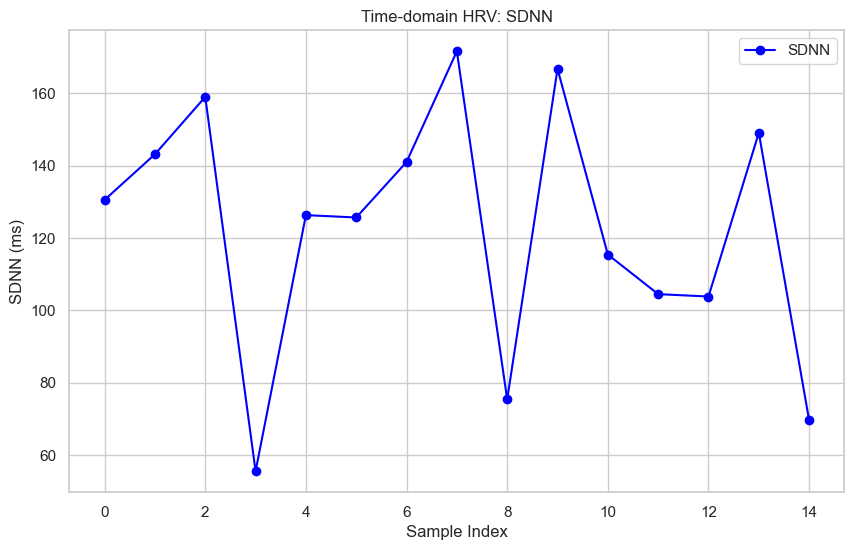

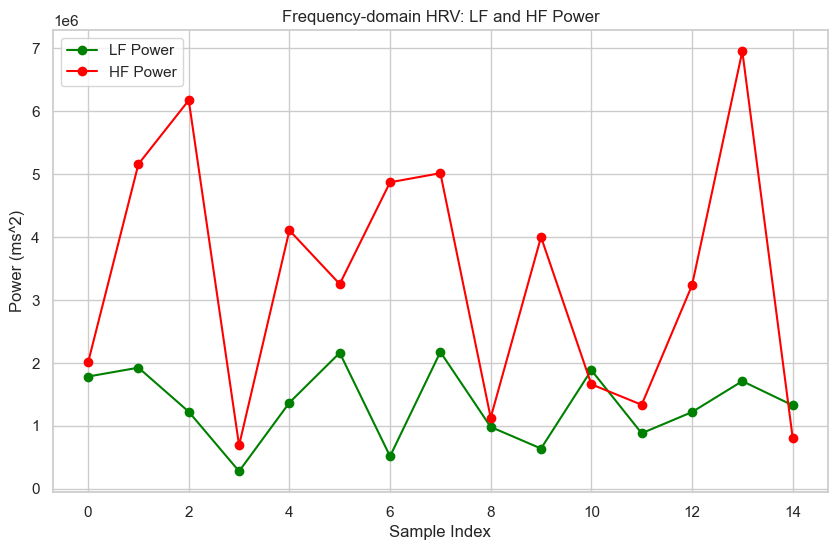

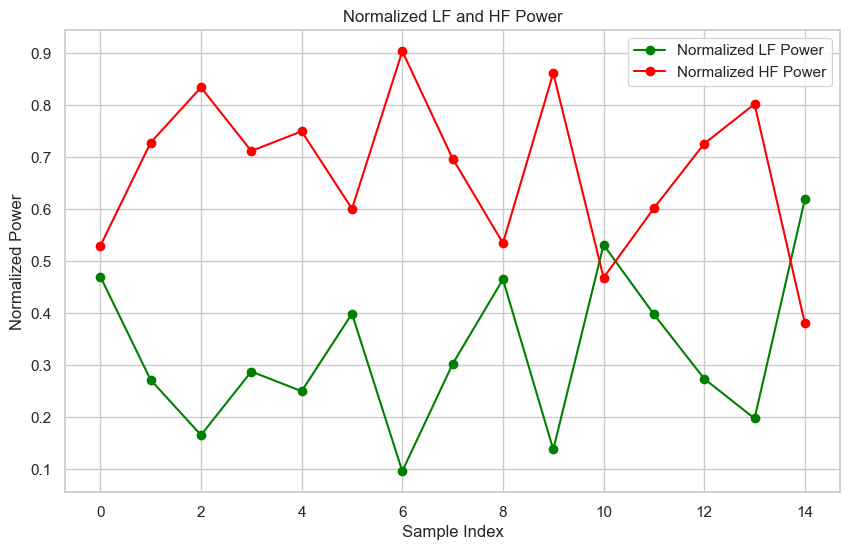

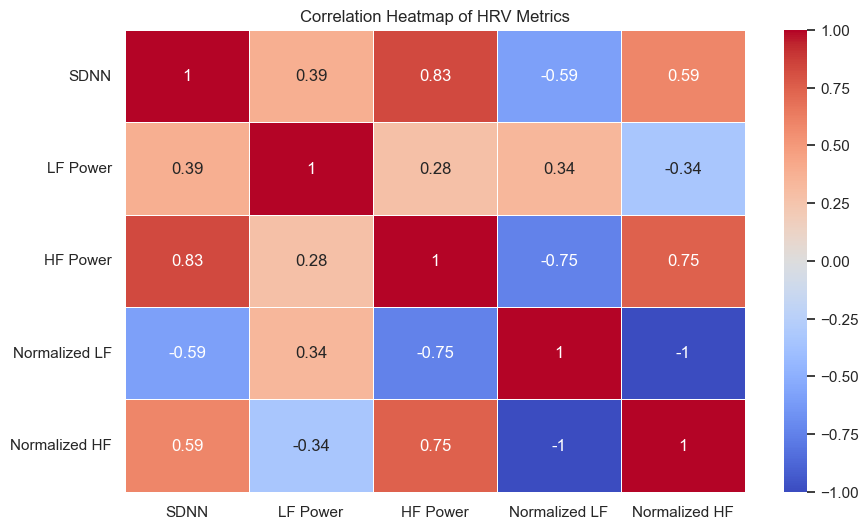

In [9]:
# Set the style of the plots for better aesthetics
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(ecg_df.index, ecg_df['sdnn'], label='SDNN', color='blue', marker='o')
plt.title('Time-domain HRV: SDNN')
plt.xlabel('Sample Index')
plt.ylabel('SDNN (ms)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ecg_df.index, ecg_df['lf_power'], label='LF Power', color='green', marker='o')
plt.plot(ecg_df.index, ecg_df['hf_power'], label='HF Power', color='red', marker='o')
plt.title('Frequency-domain HRV: LF and HF Power')
plt.xlabel('Sample Index')
plt.ylabel('Power (ms^2)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ecg_df.index, lf_normalized_filtered, label='Normalized LF Power', color='green', marker='o')
plt.plot(ecg_df.index, hf_normalized_filtered, label='Normalized HF Power', color='red', marker='o')
plt.title('Normalized LF and HF Power')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Power')
plt.grid(True)
plt.legend()
plt.show()

# Combine all HRV metrics into one DataFrame for correlation analysis
hrv_df = pd.DataFrame({
    'SDNN': ecg_df['sdnn'],
    'LF Power': ecg_df['lf_power'],
    'HF Power': ecg_df['hf_power'],
    'Normalized LF': lf_normalized_filtered,
    'Normalized HF': hf_normalized_filtered
})

# Plot a correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(hrv_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of HRV Metrics')
plt.show()


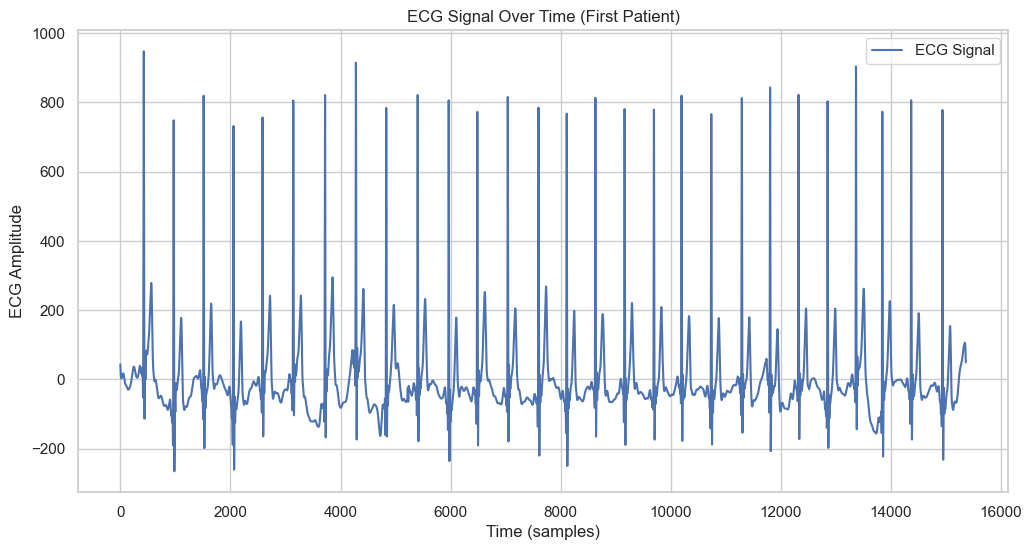

In [10]:
# Extract the ECG data for the first record
ecg_signal = ecg_df['ecg_data'][0]

# Plot ECG signal
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label='ECG Signal')
plt.title('ECG Signal Over Time (First Patient)')
plt.xlabel('Time (samples)')
plt.ylabel('ECG Amplitude')
plt.legend()
plt.grid(True)
plt.show()


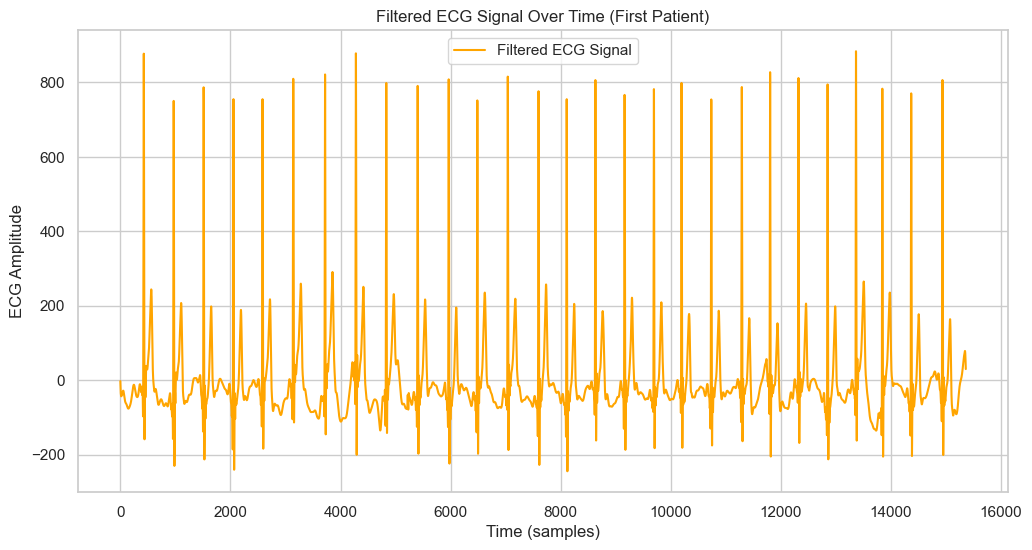

In [11]:
# Extract the filtered ECG data for the first record
filtered_ecg_signal = ecg_df['filtered_ecg'][0]

# Plot filtered ECG signal
plt.figure(figsize=(12, 6))
plt.plot(filtered_ecg_signal, label='Filtered ECG Signal', color='orange')
plt.title('Filtered ECG Signal Over Time (First Patient)')
plt.xlabel('Time (samples)')
plt.ylabel('ECG Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
print(ecg_df)

           patient             recorded_date  classification  \
0   Apoorv Mahajan 2022-04-19 15:28:49-05:00    Sinus Rhythm   
1   Apoorv Mahajan 2024-11-11 09:25:25-06:00    Sinus Rhythm   
2   Apoorv Mahajan 2022-03-29 14:02:20-05:00    Sinus Rhythm   
3   Apoorv Mahajan 2022-06-18 11:38:20-05:00    Sinus Rhythm   
4   Apoorv Mahajan 2023-04-08 05:52:12-05:00    Sinus Rhythm   
5   Apoorv Mahajan 2022-09-16 12:01:33-05:00  Poor Recording   
6   Apoorv Mahajan 2022-09-18 13:38:35-05:00    Sinus Rhythm   
7   Apoorv Mahajan 2022-05-20 13:44:53-05:00    Sinus Rhythm   
8   Apoorv Mahajan 2022-12-13 01:36:10-06:00    Sinus Rhythm   
9   Apoorv Mahajan 2022-09-23 15:11:09-05:00    Sinus Rhythm   
10  Apoorv Mahajan 2024-08-29 12:10:03-05:00    Sinus Rhythm   
11  Apoorv Mahajan 2022-03-23 01:59:46-05:00    Sinus Rhythm   
12  Apoorv Mahajan 2023-05-09 02:47:38-05:00    Sinus Rhythm   
13  Apoorv Mahajan 2022-03-20 10:28:22-05:00    Sinus Rhythm   
14  Apoorv Mahajan 2022-03-21 13:07:24-0

In [13]:
ecg_df["avg_hr_bpm"] = ecg_df["rr_intervals_filtered"].apply(
    lambda rr: round(60000 / np.mean(rr), 2) if isinstance(rr, (list, np.ndarray)) and len(rr) > 0 else np.nan
)


In [14]:
ecg_df

,patient,recorded_date,classification,ecg_data,filtered_ecg,r_peaks,rr_intervals,rr_intervals_filtered,sdnn,lf_power,hf_power,avg_hr_bpm
0,Apoorv Mahajan,2022-04-19 15:28:49-05:00,Sinus Rhythm,"[43.892, 38.552, 33.429, 28.59, 24.098, 20.01,...","[-2.314733098448509, -7.568279352485441, -12.6...","[426, 447, 470, 561, 969, 1012, 1104, 1348, 13...","[41.015625, 44.921875, 177.734375, 796.875, 83...","[796.875, 476.5625, 316.40625, 474.609375, 619...",130.524784,1.784424e+06,2.009105e+06,88.74
1,Apoorv Mahajan,2024-11-11 09:25:25-06:00,Sinus Rhythm,"[-69.291, -70.068, -70.645, -70.776, -70.163, ...","[-105.64812204126169, -106.35557289125946, -10...","[112, 134, 143, 334, 342, 367, 403, 548, 589, ...","[42.96875, 17.578125, 373.046875, 15.625, 48.8...","[373.046875, 839.84375, 912.109375, 507.8125, ...",143.118143,1.924976e+06,5.161079e+06,87.93
2,Apoorv Mahajan,2022-03-29 14:02:20-05:00,Sinus Rhythm,"[17.491, 18.837, 20.105, 21.295, 22.407, 23.44...","[8.305895379305476, 9.661963675346511, 10.9877...","[16, 158, 293, 399, 701, 834, 1189, 1321, 1578...","[277.34375, 263.671875, 207.03125, 589.84375, ...","[589.84375, 693.359375, 501.953125, 853.515625...",158.962046,1.224743e+06,6.174780e+06,89.82
3,Apoorv Mahajan,2022-06-18 11:38:20-05:00,Sinus Rhythm,"[-5.491, -4.227, -3.096, -2.099, -1.234, -0.50...","[-5.786916394115328, -4.611702692921732, -3.48...","[10, 65, 139, 232, 393, 466, 557, 733, 805, 89...","[107.421875, 144.53125, 181.640625, 314.453125...","[314.453125, 343.75, 326.171875, 447.265625, 3...",55.600293,2.788305e+05,6.898990e+05,163.19
4,Apoorv Mahajan,2023-04-08 05:52:12-05:00,Sinus Rhythm,"[13.586, 15.732, 17.779, 19.718, 21.543, 23.24...","[2.7979129519679655, 4.900315500765499, 6.9591...","[16, 181, 308, 485, 569, 622, 640, 764, 981, 1...","[322.265625, 248.046875, 345.703125, 164.0625,...","[322.265625, 345.703125, 423.828125, 548.82812...",126.315950,1.369142e+06,4.107478e+06,117.71
5,Apoorv Mahajan,2022-09-16 12:01:33-05:00,Poor Recording,"[-83.704, -88.454, -94.511, -101.436, -107.998...","[396.3963376147574, 387.32806735392046, 378.38...","[13, 36, 57, 74, 151, 299, 518, 633, 842, 906,...","[44.921875, 41.015625, 33.203125, 150.390625, ...","[427.734375, 408.203125, 660.15625, 683.59375,...",125.661903,2.160939e+06,3.254502e+06,106.22
6,Apoorv Mahajan,2022-09-18 13:38:35-05:00,Sinus Rhythm,"[-54.76, -61.602, -58.837, -51.563, -43.688, -...","[0.20214922123311282, 2.9723608633089627, 5.34...","[4, 85, 441, 574, 642, 951, 1081, 1409, 1469, ...","[158.203125, 695.3125, 259.765625, 132.8125, 6...","[695.3125, 603.515625, 640.625, 714.84375, 480...",140.983641,5.169862e+05,4.871770e+06,95.92
7,Apoorv Mahajan,2022-05-20 13:44:53-05:00,Sinus Rhythm,"[23.883, 26.609, 29.17, 31.563, 33.783, 35.824...","[-13.23005198572646, -10.361786330542955, -7.5...","[18, 141, 164, 280, 346, 414, 446, 458, 469, 6...","[240.234375, 44.921875, 226.5625, 128.90625, 1...","[390.625, 353.515625, 796.875, 345.703125, 628...",171.563933,2.174632e+06,5.016247e+06,86.76
8,Apoorv Mahajan,2022-12-13 01:36:10-06:00,Sinus Rhythm,"[-100.967, -130.421, -148.765, -152.985, -147....","[-38.15702208091258, -56.151561318443946, -71....","[66, 140, 374, 416, 440, 559, 885, 955, 997, 1...","[144.53125, 457.03125, 82.03125, 46.875, 232.4...","[457.03125, 636.71875, 734.375, 564.453125, 61...",75.422221,9.830633e+05,1.130506e+06,89.86
9,Apoorv Mahajan,2022-09-23 15:11:09-05:00,Sinus Rhythm,"[4.401, 1.963, -0.217, -2.143, -3.816, -5.244,...","[1.9329119261950123, -0.384102988929629, -2.60...","[65, 145, 287, 429, 789, 868, 1013, 1127, 1404...","[156.25, 277.34375, 277.34375, 703.125, 154.29...","[703.125, 541.015625, 664.0625, 630.859375, 35...",166.689338,6.397113e+05,4.001973e+06,85.63


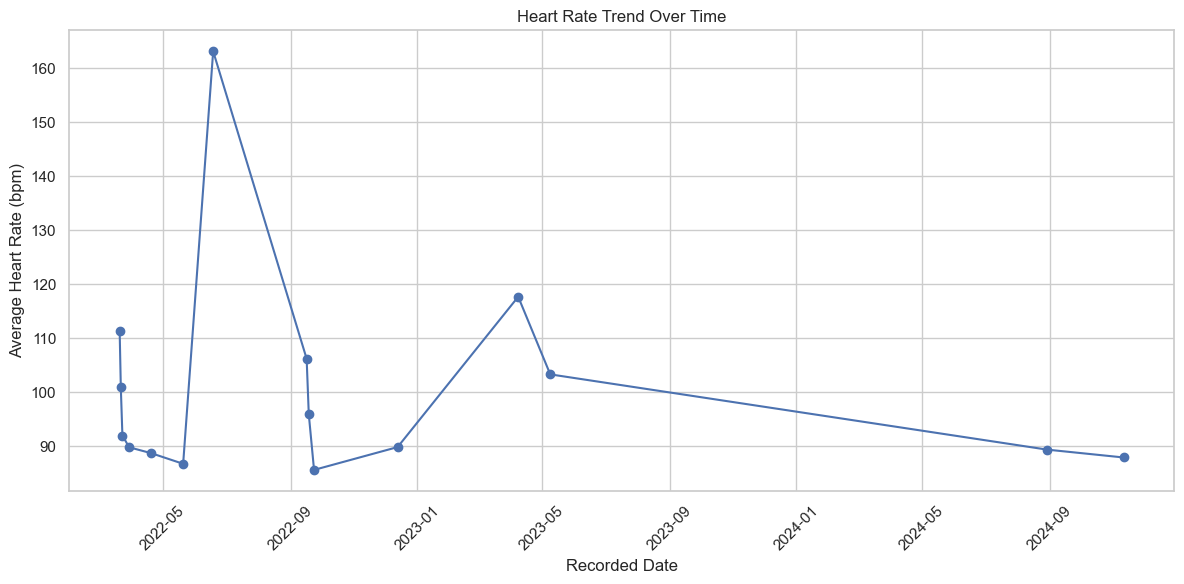

In [15]:
# Ensure recorded_date is datetime
ecg_df['recorded_date'] = pd.to_datetime(ecg_df['recorded_date'])

# Sort by date for accurate plotting
df = ecg_df.sort_values(by='recorded_date')

# Plot heart rate trend
plt.figure(figsize=(12, 6))
plt.plot(df['recorded_date'], df['avg_hr_bpm'], marker='o', linestyle='-')
plt.title('Heart Rate Trend Over Time')
plt.xlabel('Recorded Date')
plt.ylabel('Average Heart Rate (bpm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
def compute_rmssd(rr_intervals):
    rr_intervals = np.asarray(rr_intervals, dtype=np.float64)
    rr_diff = np.diff(rr_intervals)
    return np.sqrt(np.mean(rr_diff ** 2)) if rr_diff.size > 0 else np.nan

def compute_pnn50(rr_intervals):
    rr_intervals = np.asarray(rr_intervals, dtype=np.float64)
    rr_diff = np.abs(np.diff(rr_intervals))
    return np.sum(rr_diff > 50) / len(rr_diff) * 100 if rr_diff.size > 0 else np.nan

# Apply to filtered RR intervals
ecg_df["rmssd"] = ecg_df["rr_intervals_filtered"].apply(
    lambda x: compute_rmssd(x) if isinstance(x, (list, np.ndarray)) and len(x) > 1 else np.nan
)

ecg_df["pnn50"] = ecg_df["rr_intervals_filtered"].apply(
    lambda x: compute_pnn50(x) if isinstance(x, (list, np.ndarray)) and len(x) > 1 else np.nan
)

print(ecg_df.head())


          patient             recorded_date classification  \
0  Apoorv Mahajan 2022-04-19 15:28:49-05:00   Sinus Rhythm   
1  Apoorv Mahajan 2024-11-11 09:25:25-06:00   Sinus Rhythm   
2  Apoorv Mahajan 2022-03-29 14:02:20-05:00   Sinus Rhythm   
3  Apoorv Mahajan 2022-06-18 11:38:20-05:00   Sinus Rhythm   
4  Apoorv Mahajan 2023-04-08 05:52:12-05:00   Sinus Rhythm   

                                            ecg_data  \
0  [43.892, 38.552, 33.429, 28.59, 24.098, 20.01,...   
1  [-69.291, -70.068, -70.645, -70.776, -70.163, ...   
2  [17.491, 18.837, 20.105, 21.295, 22.407, 23.44...   
3  [-5.491, -4.227, -3.096, -2.099, -1.234, -0.50...   
4  [13.586, 15.732, 17.779, 19.718, 21.543, 23.24...   

                                        filtered_ecg  \
0  [-2.314733098448509, -7.568279352485441, -12.6...   
1  [-105.64812204126169, -106.35557289125946, -10...   
2  [8.305895379305476, 9.661963675346511, 10.9877...   
3  [-5.786916394115328, -4.611702692921732, -3.48...   
4  [2.7979

In [17]:
baseline_df = ecg_df[ecg_df['classification'] == 'Sinus Rhythm']

if len(baseline_df) >= 5:
    rmssd_threshold = baseline_df['rmssd'].mean() + 2 * baseline_df['rmssd'].std()
    pnn50_threshold = baseline_df['pnn50'].mean() + 2 * baseline_df['pnn50'].std()
    sdnn_threshold  = baseline_df['sdnn'].mean()  + 2 * baseline_df['sdnn'].std()
else:
    # Fallback thresholds if no baseline available
    rmssd_threshold = 150
    pnn50_threshold = 70
    sdnn_threshold  = 100


In [18]:
def detect_hrv_alert(rmssd, pnn50, sdnn):
    if rmssd > rmssd_threshold or pnn50 > pnn50_threshold or sdnn > sdnn_threshold:
        return "HRV Alert"
    return "Stable"

ecg_df['hrv_alert'] = ecg_df.apply(
    lambda row: detect_hrv_alert(row['rmssd'], row['pnn50'], row['sdnn']),
    axis=1
)


In [19]:
print(ecg_df)


           patient             recorded_date  classification  \
0   Apoorv Mahajan 2022-04-19 15:28:49-05:00    Sinus Rhythm   
1   Apoorv Mahajan 2024-11-11 09:25:25-06:00    Sinus Rhythm   
2   Apoorv Mahajan 2022-03-29 14:02:20-05:00    Sinus Rhythm   
3   Apoorv Mahajan 2022-06-18 11:38:20-05:00    Sinus Rhythm   
4   Apoorv Mahajan 2023-04-08 05:52:12-05:00    Sinus Rhythm   
5   Apoorv Mahajan 2022-09-16 12:01:33-05:00  Poor Recording   
6   Apoorv Mahajan 2022-09-18 13:38:35-05:00    Sinus Rhythm   
7   Apoorv Mahajan 2022-05-20 13:44:53-05:00    Sinus Rhythm   
8   Apoorv Mahajan 2022-12-13 01:36:10-06:00    Sinus Rhythm   
9   Apoorv Mahajan 2022-09-23 15:11:09-05:00    Sinus Rhythm   
10  Apoorv Mahajan 2024-08-29 12:10:03-05:00    Sinus Rhythm   
11  Apoorv Mahajan 2022-03-23 01:59:46-05:00    Sinus Rhythm   
12  Apoorv Mahajan 2023-05-09 02:47:38-05:00    Sinus Rhythm   
13  Apoorv Mahajan 2022-03-20 10:28:22-05:00    Sinus Rhythm   
14  Apoorv Mahajan 2022-03-21 13:07:24-0

In [21]:
import xml.etree.ElementTree as ET

def parse_and_save_health_data(xml_path, output_dir="parsed_health_data"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Collect all records
    records = []
    for record in root.findall('Record'):
        record_data = {
            'type': record.attrib.get('type'),
            'sourceName': record.attrib.get('sourceName'),
            'sourceVersion': record.attrib.get('sourceVersion'),
            'unit': record.attrib.get('unit'),
            'creationDate': record.attrib.get('creationDate'),
            'startDate': record.attrib.get('startDate'),
            'endDate': record.attrib.get('endDate'),
            'value': record.attrib.get('value'),
            'device': record.attrib.get('device')
        }
        records.append(record_data)

    # Convert to DataFrame
    df = pd.DataFrame(records)

    if df.empty:
        print("No records found in the export.")
        return

    # Group by record type and export each to a separate CSV
    grouped = df.groupby('type')
    for record_type, group_df in grouped:
        safe_name = record_type.replace("HKQuantityTypeIdentifier", "")\
                               .replace("HKCategoryTypeIdentifier", "")\
                               .replace("/", "_")
        file_path = os.path.join(output_dir, f"{safe_name}.csv")
        group_df.to_csv(file_path, index=False)

    print(f"✅ Parsed and saved {len(grouped)} record types to: {output_dir}/")

# Usage
parse_and_save_health_data('/Users/apple/Documents/Wearable/apple_health_export/export.xml')


✅ Parsed and saved 46 record types to: parsed_health_data/


In [22]:
import xml.etree.ElementTree as ET
import pandas as pd

# Load and parse the XML file
file_path = "/Users/apple/Documents/Wearable/apple_health_export/export_cda.xml"
tree = ET.parse(file_path)
root = tree.getroot()

ns = {'cda': 'urn:hl7-org:v3'}

flattened_records = []

for obs in root.findall(".//cda:observation", ns):
    try:
        code_tag = obs.find("cda:code", ns)
        value_tag = obs.find("cda:value", ns)
        time_tag = obs.find("cda:effectiveTime/cda:low", ns)
        text_tag = obs.find("cda:text", ns)

        display_name = code_tag.attrib.get("displayName", "Unknown") if code_tag is not None else "Unknown"
        value = value_tag.attrib.get("value") if value_tag is not None else None
        unit = value_tag.attrib.get("unit") if value_tag is not None else None
        timestamp = time_tag.attrib.get("value") if time_tag is not None else None
        parsed_time = pd.to_datetime(timestamp, format='%Y%m%d%H%M%S%z') if timestamp else None

        # If there are metadata entries, add a row per key-value pair
        if text_tag is not None:
            for entry in text_tag.findall("cda:metadataEntry", ns):
                key_elem = entry.find("cda:key", ns)
                val_elem = entry.find("cda:value", ns)
                if key_elem is not None and val_elem is not None:
                    flattened_records.append({
                        "type": display_name,
                        "value": float(value) if value else None,
                        "unit": unit,
                        "timestamp": parsed_time,
                        "metadata_key": key_elem.text,
                        "metadata_value": val_elem.text
                    })
        else:
            # No metadata entries, still add the core observation
            flattened_records.append({
                "type": display_name,
                "value": float(value) if value else None,
                "unit": unit,
                "timestamp": parsed_time,
                "metadata_key": None,
                "metadata_value": None
            })
    except Exception:
        continue

# Convert to DataFrame
health_df = pd.DataFrame(flattened_records)
health_df


,type,value,unit,timestamp,metadata_key,metadata_value
0,Oral fluid input,236.588,mL,2025-03-09 15:32:01-05:00,HKMetadataKeySyncVersion,1
1,Oral fluid input,236.588,mL,2025-03-09 15:32:01-05:00,HKMetadataKeySyncIdentifier,A0094C77-3E5D-465C-88C3-BA53D8CF70BF
2,Oral fluid input,250.000,mL,2025-03-09 17:12:02-05:00,HKMetadataKeySyncVersion,1
3,Oral fluid input,250.000,mL,2025-03-09 17:12:02-05:00,HKMetadataKeySyncIdentifier,B535231B-A2F1-4554-866E-E0B9705ABB67
4,Oral fluid input,250.000,mL,2025-03-09 17:36:23-05:00,HKMetadataKeySyncVersion,1
...,...,...,...,...,...,...
390338,Heart rate,109.000,count/min,2025-04-01 16:48:14-05:00,HKMetadataKeyHeartRateMotionContext,0
390339,Heart rate,80.000,count/min,2025-04-01 16:53:08-05:00,HKMetadataKeyHeartRateMotionContext,1
390340,Heart rate,72.000,count/min,2025-04-01 16:57:08-05:00,HKMetadataKeyHeartRateMotionContext,1
390341,Heart rate,69.000,count/min,2025-04-01 17:00:16-05:00,HKMetadataKeyHeartRateMotionContext,1


In [ ]:
# Ensure timestamp is datetime
health_df['timestamp'] = pd.to_datetime(health_df['timestamp'], errors='coerce')

# Ensure value is numeric
health_df['value'] = pd.to_numeric(health_df['value'], errors='coerce')

# Drop duplicates
health_df.drop_duplicates(inplace=True)

# Sort by time
health_df.sort_values('timestamp', inplace=True)

# Optional: Reset index
health_df.reset_index(drop=True, inplace=True)


In [ ]:
health_df

,type,value,unit,timestamp,metadata_key,metadata_value
0,Body weight Measured,54.4311,kg,2018-09-13 01:56:00-05:00,HKWasUserEntered,1
1,Heart rate,72.0000,count/min,2022-03-19 12:45:43-05:00,HKMetadataKeyHeartRateMotionContext,0
2,Heart rate,71.0000,count/min,2022-03-19 12:46:59-05:00,HKMetadataKeyHeartRateMotionContext,1
3,Heart rate,71.0055,count/min,2022-03-19 12:48:08-05:00,HKMetadataKeyHeartRateMotionContext,0
4,Oxygen saturation,0.9600,%,2022-03-19 12:48:30-05:00,HKMetadataKeyBarometricPressure,101.04 kPa
...,...,...,...,...,...,...
390337,Heart rate,109.0000,count/min,2025-04-01 16:48:14-05:00,HKMetadataKeyHeartRateMotionContext,0
390338,Heart rate,80.0000,count/min,2025-04-01 16:53:08-05:00,HKMetadataKeyHeartRateMotionContext,1
390339,Heart rate,72.0000,count/min,2025-04-01 16:57:08-05:00,HKMetadataKeyHeartRateMotionContext,1
390340,Heart rate,69.0000,count/min,2025-04-01 17:00:16-05:00,HKMetadataKeyHeartRateMotionContext,1


In [ ]:
# 1. Total fluid intake (example)
total_fluid_intake = health_df[health_df['type'] == 'Oral fluid input']['value'].sum()

# 2. Average fluid intake per session
average_fluid_intake = health_df[health_df['type'] == 'Oral fluid input']['value'].mean()

# 3. Syncing metadata analysis (track sync version changes)
sync_versions = health_df[health_df['metadata_key'] == 'HKMetadataKeySyncVersion']['metadata_value'].unique()

# Extracted features summary
health_features = {
    'total_fluid_intake_ml': total_fluid_intake,
    'avg_fluid_intake_ml': average_fluid_intake,
    'sync_versions': sync_versions,  # All unique versions in the health data
}
print(health_features)


{'total_fluid_intake_ml': 16213.1766, 'avg_fluid_intake_ml': 216.175688, 'sync_versions': array(['1'], dtype=object)}


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
from glob import glob
import os

# Define the folder containing GPX files
gpx_folder = "/Users/apple/Documents/Wearable/apple_health_export/workout-routes"
gpx_files = glob(os.path.join(gpx_folder, "*.gpx"))

# List to collect all parsed data
all_records = []

# Parse each GPX file
for file in gpx_files:
    try:
        tree = ET.parse(file)
        root = tree.getroot()
        ns = {'default': 'http://www.topografix.com/GPX/1/1'}

        for trkpt in root.findall(".//default:trkpt", ns):
            lat = float(trkpt.attrib.get("lat"))
            lon = float(trkpt.attrib.get("lon"))
            ele = float(trkpt.find("default:ele", ns).text) if trkpt.find("default:ele", ns) is not None else None
            time_str = trkpt.find("default:time", ns).text if trkpt.find("default:time", ns) is not None else None
            timestamp = pd.to_datetime(time_str) if time_str else None

            # Parse <extensions> without namespace
            extensions = trkpt.find("{http://www.topografix.com/GPX/1/1}extensions")
            speed = course = hAcc = vAcc = None
            if extensions is not None:
                for child in extensions:
                    tag = child.tag.split("}")[-1]  # Remove namespace
                    if tag == "speed":
                        speed = float(child.text)
                    elif tag == "course":
                        course = float(child.text)
                    elif tag == "hAcc":
                        hAcc = float(child.text)
                    elif tag == "vAcc":
                        vAcc = float(child.text)

            all_records.append({
                "latitude": lat,
                "longitude": lon,
                "elevation": ele,
                "timestamp": timestamp,
                "speed": speed,
                "course": course,
                "hAcc": hAcc,
                "vAcc": vAcc
            })

    except Exception as e:
        continue

# Convert to DataFrame
workout_df = pd.DataFrame(all_records)

# Display the parsed workout DataFrame
workout_df

,latitude,longitude,elevation,timestamp,speed,course,hAcc,vAcc
0,18.558705,73.803650,570.482648,2023-04-29 12:10:22+00:00,0.921364,169.443130,4.465510,2.917208
1,18.558697,73.803652,570.480288,2023-04-29 12:10:23+00:00,0.920433,169.408928,4.207057,2.752467
2,18.558688,73.803654,570.477772,2023-04-29 12:10:24+00:00,0.919529,169.350421,3.975205,2.605537
3,18.558680,73.803655,570.473626,2023-04-29 12:10:25+00:00,0.918560,169.240181,3.768704,2.475197
4,18.558672,73.803657,570.470589,2023-04-29 12:10:26+00:00,0.918178,169.081242,3.585926,2.360223
...,...,...,...,...,...,...,...,...
312552,18.926383,72.827335,9.873314,2023-02-11 17:39:14+00:00,0.334983,117.980269,3.866238,2.422398
312553,18.926381,72.827338,9.880497,2023-02-11 17:39:15+00:00,0.335284,117.819432,4.111682,2.536462
312554,18.926380,72.827340,9.887540,2023-02-11 17:39:16+00:00,0.335221,117.729158,4.386519,2.665791
312555,18.926378,72.827343,9.894474,2023-02-11 17:39:17+00:00,0.335006,117.689042,4.690510,2.811616


In [ ]:
import pandas as pd

workout_df["year"] = workout_df["timestamp"].dt.year

# Count the number of records per year
year_counts = workout_df["year"].value_counts().sort_index()

year_counts

year
2022      2007
2023     60252
2024    194414
2025     55884
Name: count, dtype: int64

In [ ]:
workout_df.drop(columns=["year"], inplace=True)

In [ ]:
workout_df

,latitude,longitude,elevation,timestamp,speed,course,hAcc,vAcc
0,18.558705,73.803650,570.482648,2023-04-29 12:10:22+00:00,0.921364,169.443130,4.465510,2.917208
1,18.558697,73.803652,570.480288,2023-04-29 12:10:23+00:00,0.920433,169.408928,4.207057,2.752467
2,18.558688,73.803654,570.477772,2023-04-29 12:10:24+00:00,0.919529,169.350421,3.975205,2.605537
3,18.558680,73.803655,570.473626,2023-04-29 12:10:25+00:00,0.918560,169.240181,3.768704,2.475197
4,18.558672,73.803657,570.470589,2023-04-29 12:10:26+00:00,0.918178,169.081242,3.585926,2.360223
...,...,...,...,...,...,...,...,...
312552,18.926383,72.827335,9.873314,2023-02-11 17:39:14+00:00,0.334983,117.980269,3.866238,2.422398
312553,18.926381,72.827338,9.880497,2023-02-11 17:39:15+00:00,0.335284,117.819432,4.111682,2.536462
312554,18.926380,72.827340,9.887540,2023-02-11 17:39:16+00:00,0.335221,117.729158,4.386519,2.665791
312555,18.926378,72.827343,9.894474,2023-02-11 17:39:17+00:00,0.335006,117.689042,4.690510,2.811616


In [ ]:
# Ensure timestamp is datetime
workout_df['timestamp'] = pd.to_datetime(workout_df['timestamp'], errors='coerce')

# Ensure all measurement columns are numeric
for col in ['latitude', 'longitude', 'elevation', 'speed', 'course', 'hAcc', 'vAcc']:
    workout_df[col] = pd.to_numeric(workout_df[col], errors='coerce')

# Drop duplicates
workout_df.drop_duplicates(inplace=True)

# Sort by timestamp
workout_df.sort_values('timestamp', inplace=True)

# Optional: Reset index
workout_df.reset_index(drop=True, inplace=True)


In [ ]:
workout_df

,latitude,longitude,elevation,timestamp,speed,course,hAcc,vAcc
0,18.518917,73.777299,605.041382,2022-03-24 05:20:43+00:00,0.129545,38.672638,3.057233,1.806125
1,18.518917,73.777300,604.999512,2022-03-24 05:20:43+00:00,0.142755,38.052341,2.942301,1.741756
2,18.518920,73.777301,604.871887,2022-03-24 05:20:44+00:00,0.491676,16.709145,2.473602,1.559765
3,18.518927,73.777302,604.704590,2022-03-24 05:20:45+00:00,1.010737,6.064842,2.161400,1.418727
4,18.518939,73.777303,604.503967,2022-03-24 05:20:46+00:00,1.670402,357.334503,2.061820,1.314661
...,...,...,...,...,...,...,...,...
312550,41.876513,-87.652098,182.389943,2025-04-01 18:55:38+00:00,0.049083,150.002374,6.742284,0.931691
312551,41.876512,-87.652097,182.401438,2025-04-01 18:55:39+00:00,0.049277,149.639117,7.124628,0.990175
312552,41.876512,-87.652097,182.412211,2025-04-01 18:55:40+00:00,0.049285,149.445835,7.531299,1.072719
312553,41.876511,-87.652096,182.434157,2025-04-01 18:55:42+00:00,0.049245,149.031037,8.411825,1.308148


In [ ]:
from geopy.distance import geodesic
import numpy as np

workout_df['timestamp'] = pd.to_datetime(workout_df['timestamp'])

# 1. Calculate the total distance using Haversine formula or geodesic
def calculate_distance(row1, row2):
    point1 = (row1['latitude'], row1['longitude'])
    point2 = (row2['latitude'], row2['longitude'])
    return geodesic(point1, point2).meters

# 2. Calculate total distance for entire route
workout_df['distance'] = np.nan
for i in range(1, len(workout_df)):
    workout_df.loc[i, 'distance'] = calculate_distance(workout_df.iloc[i-1], workout_df.iloc[i])

total_distance = workout_df['distance'].sum()

# 3. Calculate speed stats
average_speed = workout_df['speed'].mean()
max_speed = workout_df['speed'].max()

# 4. Elevation change (gain/loss)
elevation_gain_loss = workout_df['elevation'].max() - workout_df['elevation'].min()

# 5. Duration of the workout
workout_duration = workout_df['timestamp'].max() - workout_df['timestamp'].min()

# 6. Calculate Acceleration
workout_df['acceleration'] = workout_df['speed'].diff() / workout_df['timestamp'].diff().dt.total_seconds()
workout_df['acceleration'] = workout_df['acceleration'].fillna(0)  # Or choose dropna() to remove rows with NaN
avg_acceleration = workout_df['acceleration'].mean()

# 7. Course or bearing change over time
workout_df['course_change'] = workout_df['course'].diff()

# Extracted features summary
extracted_features = {
    'total_distance_km': total_distance / 1000,  # in kilometers
    'average_speed': average_speed,  # in count/min (assuming this is unit)
    'max_speed': max_speed,  # in count/min
    'elevation_gain_loss': elevation_gain_loss,  # in meters
    'workout_duration': workout_duration,  # in seconds
    'avg_acceleration': avg_acceleration,  # in count/min^2
}
print(extracted_features)


{'total_distance_km': 47166.73566941456, 'average_speed': 1.290662312792949, 'max_speed': 22.171861, 'elevation_gain_loss': 618.786194, 'workout_duration': Timedelta('1104 days 13:35:00'), 'avg_acceleration': nan}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
import os
import pandas as pd
from glob import glob

folder_path = "/Users/apple/Documents/Wearable/parsed_health_data"

csv_files = glob(os.path.join(folder_path, "*.csv"))

csv_dataframes = {}

for file_path in csv_files:
    try:
        df_name = os.path.splitext(os.path.basename(file_path))[0]
        df = pd.read_csv(file_path, dtype=str)
        csv_dataframes[df_name] = df
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")

print(f"Total files loaded: {len(csv_dataframes)}")
print("Sample keys:", list(csv_dataframes.keys())[:10])


Total files loaded: 47
Sample keys: ['MindfulSession', 'HeartRate', 'BodyMass', 'HandwashingEvent', 'DistanceSwimming', 'EnvironmentalSoundReduction', 'OxygenSaturation', 'StepCount', 'EnvironmentalAudioExposure', 'RunningPower']


In [ ]:
import pandas as pd

# Assuming csv_dataframes is already defined from earlier step

# Initialize a structure to hold cleaning results
cleaning_summary = []

# Data cleaning: check missing values, duplicates, and dtypes
for name, df in csv_dataframes.items():
    if isinstance(df, pd.DataFrame):
        summary = {
            "dataset": name,
            "rows": len(df),
            "columns": len(df.columns),
            "missing_values": df.isnull().sum().sum(),
            "duplicates": df.duplicated().sum(),
            "column_types": dict(df.dtypes)
        }
        cleaning_summary.append(summary)

cleaning_df = pd.DataFrame(cleaning_summary)
cleaning_df


,dataset,rows,columns,missing_values,duplicates,column_types
0,MindfulSession,16,9,32,0,"{'type': object, 'sourceName': object, 'source..."
1,HeartRate,376100,9,673,0,"{'type': object, 'sourceName': object, 'source..."
2,BodyMass,9,9,9,0,"{'type': object, 'sourceName': object, 'source..."
3,HandwashingEvent,6,9,12,1,"{'type': object, 'sourceName': object, 'source..."
4,DistanceSwimming,47,9,0,0,"{'type': object, 'sourceName': object, 'source..."
5,EnvironmentalSoundReduction,4210,9,0,0,"{'type': object, 'sourceName': object, 'source..."
6,OxygenSaturation,12517,9,0,0,"{'type': object, 'sourceName': object, 'source..."
7,StepCount,117631,9,1,0,"{'type': object, 'sourceName': object, 'source..."
8,EnvironmentalAudioExposure,46381,9,0,0,"{'type': object, 'sourceName': object, 'source..."
9,RunningPower,1,9,0,0,"{'type': object, 'sourceName': object, 'source..."


In [ ]:
def clean_health_dataframes(dataframes_dict, threshold_drop=0.95):
    cleaned_data = {}
    
    for name, df in dataframes_dict.items():
        if not isinstance(df, pd.DataFrame):
            continue

        print(f"Cleaning: {name}")

        # Standardize column names
        df.columns = df.columns.str.strip()

        # Drop duplicate rows
        df = df.drop_duplicates()

        # Drop fully empty rows
        df = df.dropna(how="all")

        # Drop columns with > threshold missing values
        missing_fraction = df.isnull().mean()
        columns_to_drop = missing_fraction[missing_fraction > threshold_drop].index.tolist()
        df = df.drop(columns=columns_to_drop)

        # If the entire DataFrame has only NaNs left (or is empty), skip it
        if df.dropna(how='all').empty:
            print(f" -> Skipped (mostly empty): {name}")
            continue

        # Convert date-like columns
        for col in df.columns:
            if 'date' in col.lower() or 'time' in col.lower():
                try:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                except Exception as e:
                    print(f" -> Could not convert column '{col}' to datetime: {e}")

        # Attempt to convert numeric columns
        for col in df.columns:
            if col not in ['type', 'unit', 'sourceName', 'sourceVersion', 'device', 'metadata']:
                try:
                    df[col] = pd.to_numeric(df[col])
                except Exception:
                    pass

        cleaned_data[name] = df

    return cleaned_data


In [ ]:
cleaned_csv_dataframes = clean_health_dataframes(csv_dataframes)



Cleaning: MindfulSession
Cleaning: HeartRate
Cleaning: BodyMass
Cleaning: HandwashingEvent
Cleaning: DistanceSwimming
Cleaning: EnvironmentalSoundReduction
Cleaning: OxygenSaturation
Cleaning: StepCount
Cleaning: EnvironmentalAudioExposure
Cleaning: RunningPower
Cleaning: RunningSpeed
Cleaning: DistanceCycling
Cleaning: WalkingAsymmetryPercentage
Cleaning: DistanceWalkingRunning
Cleaning: RespiratoryRate
Cleaning: SwimmingStrokeCount
Cleaning: RestingHeartRate
Cleaning: StairDescentSpeed
Cleaning: SixMinuteWalkTestDistance
Cleaning: Height
Cleaning: cardio_health_summary
Cleaning: AppleWalkingSteadiness
Cleaning: LowHeartRateEvent
Cleaning: VO2Max
Cleaning: HeartRateRecoveryOneMinute
Cleaning: HKDataTypeSleepDurationGoal
Cleaning: HeartRateVariabilitySDNN
Cleaning: WalkingSpeed
Cleaning: AppleExerciseTime
Cleaning: BasalEnergyBurned
Cleaning: AppleStandHour
Cleaning: WalkingHeartRateAverage
Cleaning: WalkingStepLength
Cleaning: StairAscentSpeed
Cleaning: PhysicalEffort
Cleaning: Number

In [ ]:
cleaning_summary = []

for name, df in cleaned_csv_dataframes.items():
    if isinstance(df, pd.DataFrame):
        summary = {
            "dataset": name,
            "rows": len(df),
            "columns": len(df.columns),
            "missing_values": df.isnull().sum().sum(),
            "duplicates": df.duplicated().sum(),
            "column_types": dict(df.dtypes)
        }
        cleaning_summary.append(summary)

cleaning_df = pd.DataFrame(cleaning_summary)
cleaning_df

,dataset,rows,columns,missing_values,duplicates,column_types
0,MindfulSession,16,7,0,0,"{'type': object, 'sourceName': object, 'source..."
1,HeartRate,376100,9,673,0,"{'type': object, 'sourceName': object, 'source..."
2,BodyMass,9,8,0,0,"{'type': object, 'sourceName': object, 'source..."
3,HandwashingEvent,5,7,0,0,"{'type': object, 'sourceName': object, 'source..."
4,DistanceSwimming,47,9,0,0,"{'type': object, 'sourceName': object, 'source..."
5,EnvironmentalSoundReduction,4210,9,0,0,"{'type': object, 'sourceName': object, 'source..."
6,OxygenSaturation,12517,9,0,0,"{'type': object, 'sourceName': object, 'source..."
7,StepCount,117631,9,1,0,"{'type': object, 'sourceName': object, 'source..."
8,EnvironmentalAudioExposure,46381,9,0,0,"{'type': object, 'sourceName': object, 'source..."
9,RunningPower,1,9,0,0,"{'type': object, 'sourceName': object, 'source..."


In [ ]:
def extract_features(df, dataset_name):
    features = {}
    
    # For numerical columns
    for column in df.select_dtypes(include=np.number).columns:
        features[f'{column}_mean'] = df[column].mean()
        features[f'{column}_max'] = df[column].max()
        features[f'{column}_min'] = df[column].min()
        features[f'{column}_std'] = df[column].std()
        features[f'{column}_sum'] = df[column].sum()
    
    # For categorical columns
    for column in df.select_dtypes(include='object').columns:
        features[f'{column}_unique_values'] = df[column].nunique()
        features[f'{column}_value_counts'] = df[column].value_counts().to_dict()
    
    # Time-related features
    if 'timestamp' in df.columns:
        features['time_range_days'] = (df['timestamp'].max() - df['timestamp'].min()).days
        features['num_entries'] = len(df)
    
    return features

# Apply feature extraction to all datasets
dataset_features = {}
for dataset_name, df in cleaned_csv_dataframes.items():
    dataset_features[dataset_name] = extract_features(df, dataset_name)

# Display the extracted features
for dataset_name, features in dataset_features.items():
    print(f"Features for {dataset_name}:")
    for feature, value in features.items():
        print(f"  {feature}: {value}")
    print("\n")

Features for MindfulSession:
  creationDate_mean: 1.67397579e+18
  creationDate_max: 1737684499000000000
  creationDate_min: 1647884492000000000
  creationDate_std: 3.459994030451569e+16
  creationDate_sum: 8336868566290448384
  startDate_mean: 1.672408910125e+18
  startDate_max: 1737684196000000000
  startDate_min: 1647884429000000000
  startDate_std: 3.214491559274919e+16
  startDate_sum: 8311798488290448384
  endDate_mean: 1.6724093911875e+18
  endDate_max: 1737684496000000000
  endDate_min: 1647884489000000000
  endDate_std: 3.214480839292875e+16
  endDate_sum: 8311806185290448384
  type_unique_values: 1
  type_value_counts: {'HKCategoryTypeIdentifierMindfulSession': 16}
  sourceName_unique_values: 3
  sourceName_value_counts: {'Apoorv’s Apple\xa0Watch': 12, 'Health': 2, 'Balance': 2}
  sourceVersion_unique_values: 8
  sourceVersion_value_counts: {'8.5': 7, '15.4': 2, '9.5': 2, '9.2': 1, '1912': 1, '2167': 1, '11.1': 1, '11.3': 1}
  value_unique_values: 1
  value_value_counts: {'HK

In [ ]:
for df_name, df in cleaned_csv_dataframes.items():
    print(f"### EDA for {df_name} ###\n")
    
    # Data Overview: Info, describe, missing values
    print(f"Shape: {df.shape}")
    print(f"Data Types:\n{df.dtypes}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    
    # Summary Statistics for Numerical Columns
    print(f"Summary Statistics:\n{df.describe()}")
    
    print("="*50)

### EDA for MindfulSession ###

Shape: (16, 7)
Data Types:
type             object
sourceName       object
sourceVersion    object
creationDate      int64
startDate         int64
endDate           int64
value            object
dtype: object
Missing Values:
type             0
sourceName       0
sourceVersion    0
creationDate     0
startDate        0
endDate          0
value            0
dtype: int64
Summary Statistics:
       creationDate     startDate       endDate
count  1.600000e+01  1.600000e+01  1.600000e+01
mean   1.673976e+18  1.672409e+18  1.672409e+18
std    3.459994e+16  3.214492e+16  3.214481e+16
min    1.647884e+18  1.647884e+18  1.647884e+18
25%    1.648554e+18  1.648551e+18  1.648552e+18
50%    1.648971e+18  1.648971e+18  1.648971e+18
75%    1.689917e+18  1.689901e+18  1.689902e+18
max    1.737684e+18  1.737684e+18  1.737684e+18
### EDA for HeartRate ###

Shape: (376100, 9)
Data Types:
type              object
sourceName        object
sourceVersion     object
unit        

In [ ]:
# Filling missing values for numerical columns
for df_name, df in cleaned_csv_dataframes.items():
    df.dropna(inplace=True)


In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint

def extract_features(df, dataset_name):
    features = {}

    # Numerical columns
    for column in df.select_dtypes(include=np.number).columns:
        features[f'{column}_mean'] = df[column].mean()
        features[f'{column}_max'] = df[column].max()
        features[f'{column}_min'] = df[column].min()
        features[f'{column}_std'] = df[column].std()
        features[f'{column}_sum'] = df[column].sum()

    # Categorical/object columns
    for column in df.select_dtypes(include='object').columns:
        features[f'{column}_unique_values'] = df[column].nunique()
        # Limit to top 5 most common for brevity
        value_counts = df[column].value_counts().head(5).to_dict()
        features[f'{column}_top_5_value_counts'] = value_counts

    # Time-related features
    if 'timestamp' in df.columns:
        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
            features['time_range_days'] = (df['timestamp'].max() - df['timestamp'].min()).days
        except Exception as e:
            features['time_range_days'] = f'Error: {e}'
        features['num_entries'] = len(df)

    return features

# Apply to all datasets
dataset_features = {}
for dataset_name, df in cleaned_csv_dataframes.items():
    dataset_features[dataset_name] = extract_features(df, dataset_name)

# Pretty print output
for dataset_name, features in dataset_features.items():
    print(f"\n📊 Features for **{dataset_name}**:")
    pprint(features, indent=2)



📊 Features for **MindfulSession**:
{ 'creationDate_max': 1737684499000000000,
  'creationDate_mean': 1.67397579e+18,
  'creationDate_min': 1647884492000000000,
  'creationDate_std': 3.459994030451569e+16,
  'creationDate_sum': 8336868566290448384,
  'endDate_max': 1737684496000000000,
  'endDate_mean': 1.6724093911875e+18,
  'endDate_min': 1647884489000000000,
  'endDate_std': 3.214480839292875e+16,
  'endDate_sum': 8311806185290448384,
  'sourceName_top_5_value_counts': { 'Apoorv’s Apple\xa0Watch': 12,
                                     'Balance': 2,
                                     'Health': 2},
  'sourceName_unique_values': 3,
  'sourceVersion_top_5_value_counts': { '15.4': 2,
                                        '1912': 1,
                                        '8.5': 7,
                                        '9.2': 1,
                                        '9.5': 2},
  'sourceVersion_unique_values': 8,
  'startDate_max': 1737684196000000000,
  'startDate_mean': 1.6724

/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_61042/354959608.py:26: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/apple/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


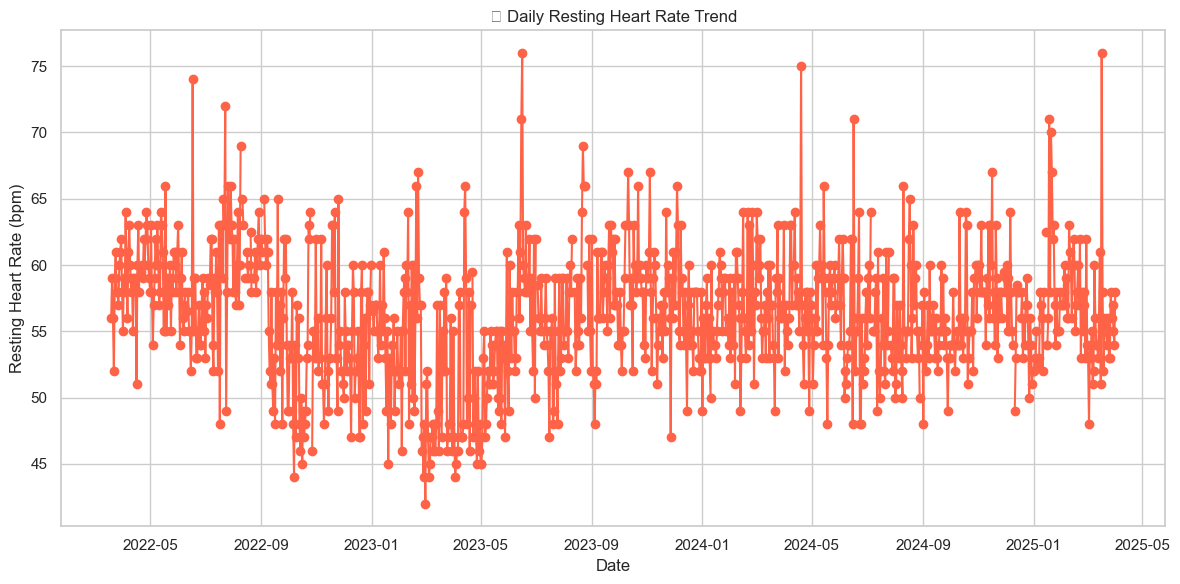

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df_rhr`
df_rhr = cleaned_csv_dataframes["RestingHeartRate"].copy()

# Convert startDate to datetime
df_rhr["startDate"] = pd.to_datetime(df_rhr["startDate"], unit='ns', errors='coerce')

# Drop NaT entries just in case
df_rhr = df_rhr.dropna(subset=["startDate"])

# Convert value to numeric (Apple Health often stores it as string)
df_rhr["value"] = pd.to_numeric(df_rhr["value"], errors="coerce")

# Resample: average daily Resting HR
daily_rhr = df_rhr.set_index("startDate").resample("D")["value"].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_rhr.index, daily_rhr.values, marker='o', linestyle='-', color='tomato')
plt.title("📉 Daily Resting Heart Rate Trend")
plt.xlabel("Date")
plt.ylabel("Resting Heart Rate (bpm)")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_61042/2022875047.py:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()


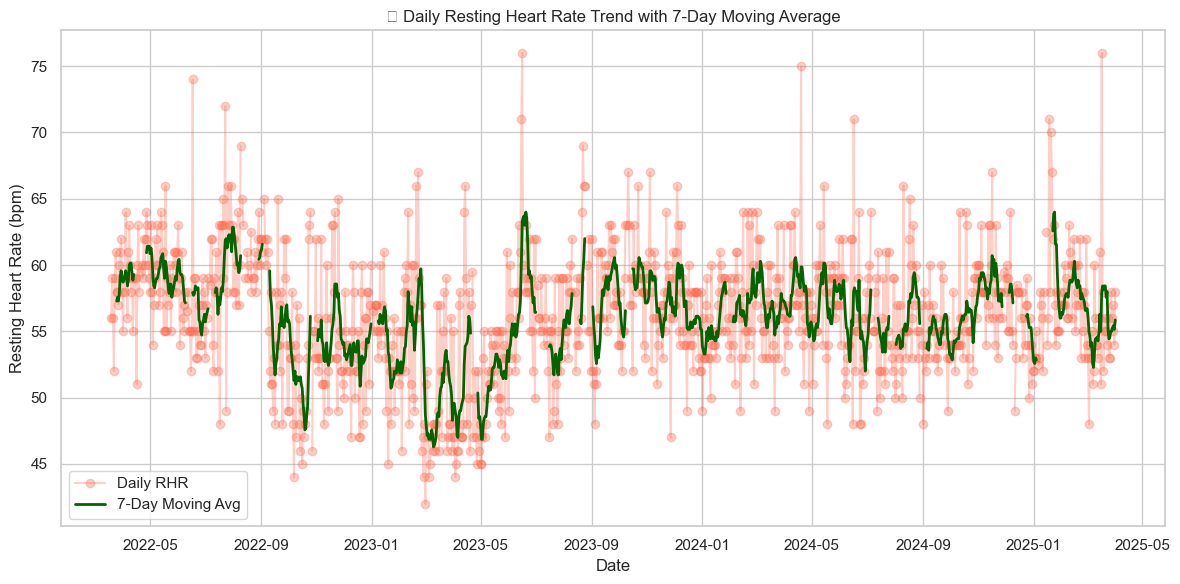

In [ ]:
# 7-day moving average
rhr_rolling = daily_rhr.rolling(window=7).mean()

# Plot original + moving average
plt.figure(figsize=(12, 6))
plt.plot(daily_rhr.index, daily_rhr.values, marker='o', linestyle='-', alpha=0.3, label='Daily RHR', color='tomato')
plt.plot(rhr_rolling.index, rhr_rolling.values, color='darkgreen', linewidth=2, label='7-Day Moving Avg')

plt.title("📉 Daily Resting Heart Rate Trend with 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Resting Heart Rate (bpm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Health Baseline Pipeline for Apple Health Data
import pandas as pd
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler

# --- Helper: Resample time-series data ---
def resample_df(df, time_col, value_col, freq='1H'):
    # Auto-detect timestamp column if not explicitly present
    for candidate in ['timestamp', 'start_time', 'startDate', 'endDate', 'creationDate', 'date', 'recorded_date']:
        if candidate in df.columns:
            time_col = candidate
            break
    else:
        raise KeyError("No valid timestamp column found.")

    df[time_col] = pd.to_datetime(df[time_col])
    return df.set_index(time_col)[value_col].resample(freq).mean().interpolate()

# --- Helper: Compute rolling baseline and z-score ---
def compute_baseline(df, value_col, window='14D'):
    df['rolling_mean'] = df[value_col].rolling(window).mean()
    df['rolling_std'] = df[value_col].rolling(window).std()
    df['zscore'] = (df[value_col] - df['rolling_mean']) / df['rolling_std']
    return df

# --- Context tagging from workout data ---
def tag_activity_context(hr_df, workout_df):
    hr_df['activity'] = 'rest'
    workout_times = pd.to_datetime(workout_df['timestamp'])
    hr_df.loc[hr_df.index.isin(workout_times), 'activity'] = 'workout'
    return hr_df

# --- ECG baseline modeling ---
def compute_ecg_baseline(ecg_df):
    features = ['sdnn', 'rmssd', 'avg_hr_bpm', 'lf_power', 'hf_power']
    ecg_features = ecg_df[features].dropna()
    model = EmpiricalCovariance().fit(ecg_features)
    ecg_scores = model.mahalanobis(ecg_features)
    ecg_df = ecg_df.loc[ecg_features.index]
    ecg_df['mahalanobis_score'] = ecg_scores
    return ecg_df, model

# --- Construct personal health vector ---
def build_health_vector(dataframes):
    vector = {}

    # Standard numeric metrics
    vector['resting_hr'] = dataframes['RestingHeartRate']['value'].astype(float).mean()
    vector['vo2max'] = dataframes['VO2Max']['value'].astype(float).mean()
    vector['hrv_sdnn'] = dataframes['HeartRateVariabilitySDNN']['value'].astype(float).mean()
    vector['step_count'] = dataframes['StepCount']['value'].astype(float).mean()

    # --- Special handling for SleepAnalysis ---
    sleep_df = dataframes['SleepAnalysis'].copy()
    sleep_df['start'] = pd.to_datetime(sleep_df['startDate'])
    sleep_df['end'] = pd.to_datetime(sleep_df['endDate'])

    # Compute duration in minutes
    sleep_df['duration_min'] = (sleep_df['end'] - sleep_df['start']).dt.total_seconds() / 60.0
    vector['sleep_duration'] = sleep_df['duration_min'].mean()

    return vector


# --- Store baselines ---
def store_baselines(dataframes):
    baseline_store = {}
    for name, df in dataframes.items():
        if 'value' in df.columns:
            try:
                values = pd.to_numeric(df['value'], errors='coerce')
                values = values.dropna()
                if not values.empty:
                    baseline_store[name] = {
                        'mean': values.mean(),
                        'std': values.std()
                    }
            except Exception as e:
                print(f"Skipping {name} due to error: {e}")
    return baseline_store


# --- Process mixed health_df ---
def process_health_df(health_df):
    metric_dfs = {}
    for metric in health_df['type'].unique():
        df = health_df[health_df['type'] == metric].copy()
        for candidate in ['timestamp', 'start_time', 'date', 'recorded_date']:
            if candidate in df.columns:
                df[candidate] = pd.to_datetime(df[candidate])
                df = df[['value', candidate]].copy()
                df['value'] = pd.to_numeric(df['value'], errors='coerce')
                df.dropna(inplace=True)
                df = resample_df(df, time_col=candidate, value_col='value')
                df = compute_baseline(df.to_frame(name='value'), 'value')
                metric_dfs[metric] = df
                break
    return metric_dfs



In [ ]:
ecg_df

,patient,recorded_date,classification,ecg_data,filtered_ecg,r_peaks,rr_intervals,rr_intervals_filtered,sdnn,lf_power,hf_power,avg_hr_bpm,rmssd,pnn50,hrv_alert
0,Apoorv Mahajan,2022-04-19 15:28:49-05:00,Sinus Rhythm,"[43.892, 38.552, 33.429, 28.59, 24.098, 20.01,...","[-2.314733098448509, -7.568279352485441, -12.6...","[426, 447, 470, 561, 969, 1012, 1104, 1348, 13...","[41.015625, 44.921875, 177.734375, 796.875, 83...","[796.875, 476.5625, 316.40625, 474.609375, 619...",130.524784,1.784424e+06,2.009105e+06,88.74,129.829830,78.571429,Stable
1,Apoorv Mahajan,2024-11-11 09:25:25-06:00,Sinus Rhythm,"[-69.291, -70.068, -70.645, -70.776, -70.163, ...","[-105.64812204126169, -106.35557289125946, -10...","[112, 134, 143, 334, 342, 367, 403, 548, 589, ...","[42.96875, 17.578125, 373.046875, 15.625, 48.8...","[373.046875, 839.84375, 912.109375, 507.8125, ...",143.118143,1.924976e+06,5.161079e+06,87.93,184.661860,77.777778,Stable
2,Apoorv Mahajan,2022-03-29 14:02:20-05:00,Sinus Rhythm,"[17.491, 18.837, 20.105, 21.295, 22.407, 23.44...","[8.305895379305476, 9.661963675346511, 10.9877...","[16, 158, 293, 399, 701, 834, 1189, 1321, 1578...","[277.34375, 263.671875, 207.03125, 589.84375, ...","[589.84375, 693.359375, 501.953125, 853.515625...",158.962046,1.224743e+06,6.174780e+06,89.82,224.331901,82.758621,Stable
3,Apoorv Mahajan,2022-06-18 11:38:20-05:00,Sinus Rhythm,"[-5.491, -4.227, -3.096, -2.099, -1.234, -0.50...","[-5.786916394115328, -4.611702692921732, -3.48...","[10, 65, 139, 232, 393, 466, 557, 733, 805, 89...","[107.421875, 144.53125, 181.640625, 314.453125...","[314.453125, 343.75, 326.171875, 447.265625, 3...",55.600293,2.788305e+05,6.898990e+05,163.19,80.731323,42.857143,Stable
4,Apoorv Mahajan,2023-04-08 05:52:12-05:00,Sinus Rhythm,"[13.586, 15.732, 17.779, 19.718, 21.543, 23.24...","[2.7979129519679655, 4.900315500765499, 6.9591...","[16, 181, 308, 485, 569, 622, 640, 764, 981, 1...","[322.265625, 248.046875, 345.703125, 164.0625,...","[322.265625, 345.703125, 423.828125, 548.82812...",126.315950,1.369142e+06,4.107478e+06,117.71,180.852349,65.625000,Stable
5,Apoorv Mahajan,2022-09-16 12:01:33-05:00,Poor Recording,"[-83.704, -88.454, -94.511, -101.436, -107.998...","[396.3963376147574, 387.32806735392046, 378.38...","[13, 36, 57, 74, 151, 299, 518, 633, 842, 906,...","[44.921875, 41.015625, 33.203125, 150.390625, ...","[427.734375, 408.203125, 660.15625, 683.59375,...",125.661903,2.160939e+06,3.254502e+06,106.22,181.237894,79.310345,Stable
6,Apoorv Mahajan,2022-09-18 13:38:35-05:00,Sinus Rhythm,"[-54.76, -61.602, -58.837, -51.563, -43.688, -...","[0.20214922123311282, 2.9723608633089627, 5.34...","[4, 85, 441, 574, 642, 951, 1081, 1409, 1469, ...","[158.203125, 695.3125, 259.765625, 132.8125, 6...","[695.3125, 603.515625, 640.625, 714.84375, 480...",140.983641,5.169862e+05,4.871770e+06,95.92,242.685676,78.571429,Stable
7,Apoorv Mahajan,2022-05-20 13:44:53-05:00,Sinus Rhythm,"[23.883, 26.609, 29.17, 31.563, 33.783, 35.824...","[-13.23005198572646, -10.361786330542955, -7.5...","[18, 141, 164, 280, 346, 414, 446, 458, 469, 6...","[240.234375, 44.921875, 226.5625, 128.90625, 1...","[390.625, 353.515625, 796.875, 345.703125, 628...",171.563933,2.174632e+06,5.016247e+06,86.76,214.210099,73.076923,Stable
8,Apoorv Mahajan,2022-12-13 01:36:10-06:00,Sinus Rhythm,"[-100.967, -130.421, -148.765, -152.985, -147....","[-38.15702208091258, -56.151561318443946, -71....","[66, 140, 374, 416, 440, 559, 885, 955, 997, 1...","[144.53125, 457.03125, 82.03125, 46.875, 232.4...","[457.03125, 636.71875, 734.375, 564.453125, 61...",75.422221,9.830633e+05,1.130506e+06,89.86,87.846488,53.333333,Stable
9,Apoorv Mahajan,2022-09-23 15:11:09-05:00,Sinus Rhythm,"[4.401, 1.963, -0.217, -2.143, -3.816, -5.244,...","[1.9329119261950123, -0.384102988929629, -2.60...","[65, 145, 287, 429, 789, 868, 1013, 1127, 1404...","[156.25, 277.34375, 277.34375, 703.125, 154.29...","[703.125, 541.015625, 664.0625, 630.859375, 35...",166.689338,6.397113e+05,4.001973e+06,85.6

In [ ]:

# --- 1. Resample and Compute Baseline for Heart Rate ---
heart_rate_df = cleaned_csv_dataframes['HeartRate'].copy()
heart_rate_df = resample_df(heart_rate_df, time_col='start_time', value_col='value')
heart_rate_df = compute_baseline(heart_rate_df.to_frame(name='value'), 'value')

# --- 2. Add Activity Context to Heart Rate ---
workout_df['timestamp'] = pd.to_datetime(workout_df['timestamp'])
heart_rate_df = tag_activity_context(heart_rate_df, workout_df)

# --- 3. Compute ECG Health Baseline Model ---
ecg_df_processed, ecg_model = compute_ecg_baseline(ecg_df)

# --- 4. Generate Personal Health Vector ---
personal_vector = build_health_vector(cleaned_csv_dataframes)

# --- 5. Store Global Baseline Stats Across All Metrics ---
global_baseline_stats = store_baselines(cleaned_csv_dataframes)

# --- 6. Example Output ---
print("Personal Health Vector:")
print(personal_vector)

print("\nBaseline Stats for HeartRate:")
print(global_baseline_stats['HeartRate'])

print("\nFirst few Mahalanobis Scores from ECG:")
print(ecg_df_processed[['recorded_date', 'mahalanobis_score']].head())


Personal Health Vector:
{'resting_hr': 56.23534715960324, 'vo2max': 39.56279411764706, 'hrv_sdnn': 64.98992575502444, 'step_count': 116.80339199183882, 'sleep_duration': 25.809279741237248}

Baseline Stats for HeartRate:
{'mean': 72.58310204114251, 'std': 22.37545513374301}

First few Mahalanobis Scores from ECG:
              recorded_date  mahalanobis_score
0 2022-04-19 15:28:49-05:00           3.868978
1 2024-11-11 09:25:25-06:00           2.673898
2 2022-03-29 14:02:20-05:00           2.854706
3 2022-06-18 11:38:20-05:00          11.745263
4 2023-04-08 05:52:12-05:00           1.425720


/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_61042/2621714790.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.set_index(time_col)[value_col].resample(freq).mean().interpolate()


Health Profile Output
Resting HR: ~56.24 bpm
VO₂Max: ~39.56 ml/kg/min
HRV (SDNN): ~64.99 ms
Step Count Mean: ~116 steps/hour (resampled)
Sleep Duration Mean: ~25.8 minutes per entry (make sure SleepAnalysis includes only actual "Asleep" states, not all segments)

Heart Rate Baseline
Mean: 72.58 bpm
Std Dev: 22.38 bpm

ECG Mahalanobis Scores
Detected outlier: Mahalanobis score > 11 (entry from 2022-06-18)
Most are in typical range (score < 5)

In [ ]:
def split_health_df_by_type(health_df):
    metric_dfs = {}
    for metric in health_df['type'].unique():
        metric_df = health_df[health_df['type'] == metric].copy()
        metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp'])
        metric_df.sort_values('timestamp', inplace=True)
        metric_dfs[metric] = metric_df
    return metric_dfs

health_df_dfs = split_health_df_by_type(health_df)


In [ ]:
for name, df in health_df_dfs.items():
    df = df[['timestamp', 'value']].copy()
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.dropna(inplace=True)
    df_resampled = resample_df(df, time_col='timestamp', value_col='value')
    df_baseline = compute_baseline(df_resampled.to_frame(name='value'), 'value')
    health_df_dfs[name] = df_baseline


/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_61042/2621714790.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.set_index(time_col)[value_col].resample(freq).mean().interpolate()
/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_61042/2621714790.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.set_index(time_col)[value_col].resample(freq).mean().interpolate()
/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_61042/2621714790.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.set_index(time_col)[value_col].resample(freq).mean().interpolate()
/var/folders/xj/ryc16r753yl574_b171p02dh0000gn/T/ipykernel_61042/2621714790.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.set_index(time_col)[value_c

In [ ]:
additional_baselines = store_baselines(health_df_dfs)
global_baseline_stats.update(additional_baselines)


In [ ]:
print("Oxygen Saturation Baseline:")
print(global_baseline_stats.get('Oxygen saturation'))

print("\nBody Weight Trend:")
print(health_df_dfs['Body weight Measured'].tail())


Oxygen Saturation Baseline:
{'mean': 0.974485980138007, 'std': 0.02004900047513719}

Body Weight Trend:
                               value  rolling_mean  rolling_std    zscore
timestamp                                                                
2024-04-09 20:00:00-05:00  66.052288     67.551507     0.605653 -2.475379
2024-04-09 21:00:00-05:00  66.039216     67.545819     0.610847 -2.466416
2024-04-09 22:00:00-05:00  66.026144     67.540090     0.616040 -2.457547
2024-04-09 23:00:00-05:00  66.013072     67.534322     0.621231 -2.448768
2024-04-10 00:00:00-05:00  66.000000     67.528514     0.626420 -2.440079


Insights from This Output:
Oxygen Saturation
Mean: ~97.45%
Std Dev: ~2.00%
A z-score threshold of ±2.5 would catch potential respiratory irregularities (e.g., <92%).

Body Weight Trend
Current weight: ~66.0 kg
Rolling baseline: ~67.5 kg
Z-score: −2.44 to −2.47
Significant downward deviation (possibly intentional weight loss or alert-worthy trend).

In [ ]:
baseline_summary = pd.DataFrame(global_baseline_stats).T.reset_index()
baseline_summary.columns = ['metric', 'mean', 'std']
baseline_summary.to_csv("baseline_summary.csv", index=False)


In [ ]:
body_weight_df = health_df_dfs['Body weight Measured'].copy()
body_weight_df.reset_index(inplace=True)
body_weight_df.to_csv("body_weight_zscore.csv", index=False)


In [ ]:
ecg_df_processed[['recorded_date', 'mahalanobis_score']].to_csv("ecg_anomalies.csv", index=False)


In [ ]:
pd.DataFrame([personal_vector]).to_csv("personal_vector.csv", index=False)


In [ ]:
# Health Baseline Pipeline for Apple Health Data
import pandas as pd
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler

# --- Helper: Resample time-series data ---
def resample_df(df, time_col, value_col, freq='1h'):
    # Auto-detect timestamp column if not explicitly present
    for candidate in ['timestamp', 'start_time', 'startDate', 'endDate', 'creationDate', 'date', 'recorded_date']:
        if candidate in df.columns:
            time_col = candidate
            break
    else:
        raise KeyError("No valid timestamp column found.")

    df[time_col] = pd.to_datetime(df[time_col])
    return df.set_index(time_col)[value_col].resample(freq).mean().interpolate()

# --- Helper: Compute rolling baseline and z-score ---
def compute_baseline(df, value_col, window='14D'):
    df['rolling_mean'] = df[value_col].rolling(window).mean()
    df['rolling_std'] = df[value_col].rolling(window).std()
    df['zscore'] = (df[value_col] - df['rolling_mean']) / df['rolling_std']
    return df

# --- Context tagging from workout data ---
def tag_activity_context(hr_df, workout_df):
    hr_df['activity'] = 'rest'
    workout_times = pd.to_datetime(workout_df['timestamp'])
    hr_df.loc[hr_df.index.isin(workout_times), 'activity'] = 'workout'
    return hr_df

# --- ECG baseline modeling ---
def compute_ecg_baseline(ecg_df):
    features = ['sdnn', 'rmssd', 'avg_hr_bpm', 'lf_power', 'hf_power']
    ecg_features = ecg_df[features].dropna()
    model = EmpiricalCovariance().fit(ecg_features)
    ecg_scores = model.mahalanobis(ecg_features)
    ecg_df = ecg_df.loc[ecg_features.index]
    ecg_df['mahalanobis_score'] = ecg_scores
    return ecg_df, model

# --- Construct personal health vector ---
def build_health_vector(dataframes):
    vector = {}

    # Standard numeric metrics
    vector['resting_hr'] = dataframes['RestingHeartRate']['value'].astype(float).mean()
    vector['vo2max'] = dataframes['VO2Max']['value'].astype(float).mean()
    vector['hrv_sdnn'] = dataframes['HeartRateVariabilitySDNN']['value'].astype(float).mean()
    vector['step_count'] = dataframes['StepCount']['value'].astype(float).mean()

    # --- Special handling for SleepAnalysis ---
    sleep_df = dataframes['SleepAnalysis'].copy()
    sleep_df['start'] = pd.to_datetime(sleep_df['startDate'])
    sleep_df['end'] = pd.to_datetime(sleep_df['endDate'])
    sleep_df['duration_min'] = (sleep_df['end'] - sleep_df['start']).dt.total_seconds() / 60.0
    vector['sleep_duration'] = sleep_df['duration_min'].mean()

    return vector

# --- Store baselines ---
def store_baselines(dataframes):
    baseline_store = {}
    for name, df in dataframes.items():
        if 'value' in df.columns:
            try:
                values = pd.to_numeric(df['value'], errors='coerce').dropna()
                if not values.empty:
                    baseline_store[name] = {
                        'mean': values.mean(),
                        'std': values.std()
                    }
            except Exception as e:
                print(f"Skipping {name} due to error: {e}")
    return baseline_store

# --- Process mixed health_df ---
def process_health_df(health_df):
    metric_dfs = {}
    for metric in health_df['type'].unique():
        df = health_df[health_df['type'] == metric].copy()
        for candidate in ['timestamp', 'start_time', 'startDate', 'endDate', 'creationDate', 'date', 'recorded_date']:
            if candidate in df.columns:
                df[candidate] = pd.to_datetime(df[candidate])
                df = df[['value', candidate]].copy()
                df['value'] = pd.to_numeric(df['value'], errors='coerce')
                df.dropna(inplace=True)
                df = resample_df(df, time_col=candidate, value_col='value')
                df = compute_baseline(df.to_frame(name='value'), 'value')
                metric_dfs[metric] = df
                break
    return metric_dfs

# --- Export baseline-processed z-score datasets for Tableau ---
def export_all_zscore_metrics(dataframes, out_dir='tableau_exports'):
    import os
    os.makedirs(out_dir, exist_ok=True)
    for name, df in dataframes.items():
        if 'zscore' in df.columns:
            df_reset = df.reset_index()
            filename = f"{out_dir}/{name.replace(' ', '_').lower()}_zscore.csv"
            df_reset.to_csv(filename, index=False)




In [ ]:
export_all_zscore_metrics(health_df_dfs, out_dir='tableau_exports')


In [ ]:
rhr_df = cleaned_csv_dataframes['RestingHeartRate'].copy()
rhr_df['timestamp'] = pd.to_datetime(rhr_df['endDate'], unit='ns')


In [ ]:
rhr_df = rhr_df[['timestamp', 'value']].dropna()
rhr_df = rhr_df.sort_values('timestamp')
rhr_df

,timestamp,value
0,2022-03-19 19:51:40,62
1,2022-03-20 16:32:32,50
2,2022-03-21 18:25:21,59
3,2022-03-22 16:00:20,56
4,2022-03-23 15:32:26,52
...,...,...
1104,2025-03-28 21:00:14,56
1105,2025-03-30 04:12:12,57
1106,2025-03-30 18:32:17,55
1107,2025-04-01 02:09:26,54


In [ ]:
from generate_cardio_dashboard_data import convert_and_export_cardio_data

export_dir = "/Users/apple/Documents/Wearable/tableau_exports"
exported = convert_and_export_cardio_data(cleaned_csv_dataframes, export_dir)

for file in exported:
    print("✅ Exported:", file)


✅ Exported: /Users/apple/Documents/Wearable/tableau_exports/restingheartrate_zscore.csv
✅ Exported: /Users/apple/Documents/Wearable/tableau_exports/hrv_sdnn_zscore.csv
✅ Exported: /Users/apple/Documents/Wearable/tableau_exports/hr_recovery_zscore.csv
✅ Exported: /Users/apple/Documents/Wearable/tableau_exports/vo2max_zscore.csv


In [ ]:
from generate_Sleep import convert_and_export_sleep_data


# Set export directory
export_dir = "/Users/apple/Documents/Wearable/tableau_exports"
os.makedirs(export_dir, exist_ok=True)

# Run all export functions
sleep_export = convert_and_export_sleep_data(cleaned_csv_dataframes, export_dir)

print("✅ Sleep export:", sleep_export)


✅ Sleep export: /Users/apple/Documents/Wearable/tableau_exports/sleep_analysis_zscore.csv


In [ ]:
from generate_Activity import convert_and_export_activity_data
from generate_Lifestyle import convert_and_export_lifestyle_data

# Set export directory
export_dir = "/Users/apple/Documents/Wearable/tableau_exports"
os.makedirs(export_dir, exist_ok=True)

# Run all export functions
activity_exports = convert_and_export_activity_data(cleaned_csv_dataframes, export_dir, workout_df)
lifestyle_exports = convert_and_export_lifestyle_data(cleaned_csv_dataframes, export_dir)

print("✅ Activity exports:", activity_exports)
print("✅ Lifestyle exports:", lifestyle_exports)

✅ Activity exports: ['/Users/apple/Documents/Wearable/tableau_exports/exercise_time_zscore.csv', '/Users/apple/Documents/Wearable/tableau_exports/active_energy_zscore.csv', '/Users/apple/Documents/Wearable/tableau_exports/walking_running_distance_zscore.csv', 'workout_speed_zscore.csv', 'workout_acceleration_zscore.csv', 'workout_distance_zscore.csv']
✅ Lifestyle exports: ['/Users/apple/Documents/Wearable/tableau_exports/time_in_daylight_zscore.csv', '/Users/apple/Documents/Wearable/tableau_exports/headphone_audio_zscore.csv', '/Users/apple/Documents/Wearable/tableau_exports/env_audio_exposure_zscore.csv']


In [ ]:
import pandas as pd

exercise_time_zscore = pd.read_csv("/Users/apple/Documents/Wearable/tableau_exports/exercise_time_zscore.csv")
exercise_time_zscore.head()

,timestamp,value,rolling_mean,rolling_std,zscore
0,2022-03-19,8,8.000000,NaN,NaN
1,2022-03-20,19,13.500000,7.778175,0.707107
2,2022-03-22,2,9.666667,8.621678,-0.889231
3,2022-03-23,5,8.500000,7.416198,-0.471940
4,2022-03-24,12,9.200000,6.610598,0.423562


In [ ]:
env_audio_exposure_zscore = pd.read_csv("/Users/apple/Documents/Wearable/tableau_exports/env_audio_exposure_zscore.csv")
env_audio_exposure_zscore.head()




,timestamp,value,rolling_mean,rolling_std,zscore
0,2022-03-19,900.5230,900.523000,NaN,NaN
1,2022-03-20,2630.4849,1765.503950,1223.267791,0.707107
2,2022-03-21,1910.8543,1813.954067,869.042165,0.111502
3,2022-03-22,2045.7911,1871.913325,718.976096,0.241841
4,2022-03-23,1790.6035,1855.651360,623.712455,-0.104291


In [ ]:
# Define paths again due to kernel reset
export_dir = "/Users/apple/Documents/Wearable/tableau_exports"
files = {
    "Environmental Audio Exposure": "env_audio_exposure_zscore.csv",
    "Headphone Audio Exposure": "headphone_audio_zscore.csv",
    "Time in Daylight": "time_in_daylight_zscore.csv"
}

combined = []

for label, filename in files.items():
    file_path = os.path.join(export_dir, filename)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Metric"] = label
        combined.append(df)

# Concatenate all data
lifestyle_union_df = pd.concat(combined, ignore_index=True)

# Export the unioned file
output_path = os.path.join(export_dir, "lifestyle_union_zscore.csv")
lifestyle_union_df.to_csv(output_path, index=False)

lifestyle_union_df
output_path


'/Users/apple/Documents/Wearable/tableau_exports/lifestyle_union_zscore.csv'

In [ ]:
lifestyle_union_df

,timestamp,value,rolling_mean,rolling_std,zscore,Metric
0,2022-03-19,900.5230,900.523000,NaN,NaN,Environmental Audio Exposure
1,2022-03-20,2630.4849,1765.503950,1223.267791,0.707107,Environmental Audio Exposure
2,2022-03-21,1910.8543,1813.954067,869.042165,0.111502,Environmental Audio Exposure
3,2022-03-22,2045.7911,1871.913325,718.976096,0.241841,Environmental Audio Exposure
4,2022-03-23,1790.6035,1855.651360,623.712455,-0.104291,Environmental Audio Exposure
...,...,...,...,...,...,...
2443,2025-03-25,7.0000,28.428571,18.329004,-1.169107,Time in Daylight
2444,2025-03-27,34.0000,30.571429,17.915144,0.191378,Time in Daylight
2445,2025-03-28,55.0000,36.714286,17.857905,1.023956,Time in Daylight
2446,2025-03-31,90.0000,46.285714,25.571562,1.709488,Time in Daylight


In [ ]:
import pandas as pd
import os

# File paths from Activity exports
activity_files = [
    '/Users/apple/Documents/Wearable/tableau_exports/exercise_time_zscore.csv',
    '/Users/apple/Documents/Wearable/tableau_exports/active_energy_zscore.csv',
    '/Users/apple/Documents/Wearable/tableau_exports/walking_running_distance_zscore.csv',
    '/Users/apple/Documents/Wearable/tableau_exports/workout_speed_zscore.csv',
    '/Users/apple/Documents/Wearable/tableau_exports/workout_acceleration_zscore.csv',
    '/Users/apple/Documents/Wearable/tableau_exports/workout_distance_zscore.csv',
]

# Map filenames to clean metric labels
label_map = {
    'exercise_time_zscore.csv': 'Exercise Time',
    'active_energy_zscore.csv': 'Active Energy Burned',
    'walking_running_distance_zscore.csv': 'Distance Walked/Run',
    'workout_speed_zscore.csv': 'Workout Speed',
    'workout_acceleration_zscore.csv': 'Workout Acceleration',
    'workout_distance_zscore.csv': 'Workout Distance',
}

# Load and combine
combined_df = pd.DataFrame()
for file_path in activity_files:
    df = pd.read_csv(file_path)
    df['Metric'] = label_map[os.path.basename(file_path)]
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Output path
output_path = '/Users/apple/Documents/Wearable/tableau_exports/activity_union_zscore.csv'
combined_df.to_csv(output_path, index=False)

combined_df

,timestamp,value,rolling_mean,rolling_std,zscore,Metric
0,2022-03-19,8.000000,8.000000,NaN,NaN,Exercise Time
1,2022-03-20,19.000000,13.500000,7.778175,0.707107,Exercise Time
2,2022-03-22,2.000000,9.666667,8.621678,-0.889231,Exercise Time
3,2022-03-23,5.000000,8.500000,7.416198,-0.471940,Exercise Time
4,2022-03-24,12.000000,9.200000,6.610598,0.423562,Exercise Time
...,...,...,...,...,...,...
4326,2025-03-24,1094.653749,2447.808706,1952.450262,-0.693055,Workout Distance
4327,2025-03-27,1244.920973,2318.382796,2004.740224,-0.535462,Workout Distance
4328,2025-03-28,2383.822710,2275.779331,1998.884087,0.054052,Workout Distance
4329,2025-03-31,1262.000714,2129.140120,2035.120392,-0.426088,Workout Distance


In [ ]:
import pandas as pd
import os

# Updated CSV paths
csv_paths = {
    "RestingHeartRate": "tableau_exports/restingheartrate_zscore.csv",
    "HRV": "tableau_exports/hrv_sdnn_zscore.csv",
    "ExerciseTime": "tableau_exports/exercise_time_zscore.csv",
    "Sleep": "tableau_exports/sleep_analysis_zscore.csv",
    "Daylight": "tableau_exports/time_in_daylight_zscore.csv",
    "HeadphoneAudio": "tableau_exports/headphone_audio_zscore.csv"
}

# Load CSVs into dictionary
data = {}
missing_files = []

for name, path in csv_paths.items():
    if os.path.exists(path):
        df = pd.read_csv(path, parse_dates=["timestamp"])
        df["Metric"] = name
        data[name] = df
    else:
        missing_files.append(path)

data_loaded_keys = list(data.keys())



In [ ]:
data_loaded_keys

['RestingHeartRate',
 'HRV',
 'ExerciseTime',
 'Sleep',
 'Daylight',
 'HeadphoneAudio']

In [ ]:
from datetime import datetime
from functools import reduce

# Group each metric by week and average the z-score
weekly_metric_dfs = {}

for metric, df in data.items():
    df["week"] = df["timestamp"].dt.to_period("W").apply(lambda r: r.start_time)
    weekly_avg = df.groupby("week")["zscore"].mean().reset_index()
    weekly_avg.rename(columns={"zscore": metric}, inplace=True)
    weekly_metric_dfs[metric] = weekly_avg


In [ ]:
# Merge all metrics on the 'week' column
weekly_combined = reduce(lambda left, right: pd.merge(left, right, on="week", how="outer"), weekly_metric_dfs.values())


In [ ]:
weekly_combined

,week,RestingHeartRate,HRV,ExerciseTime,Sleep,Daylight,HeadphoneAudio
0,2021-11-15,NaN,NaN,NaN,NaN,NaN,0.083876
1,2021-11-22,NaN,NaN,NaN,NaN,NaN,-0.431998
2,2021-11-29,NaN,NaN,NaN,NaN,NaN,0.218802
3,2021-12-06,NaN,NaN,NaN,NaN,NaN,0.496702
4,2021-12-13,NaN,NaN,NaN,NaN,NaN,-0.035912
...,...,...,...,...,...,...,...
171,2025-03-03,-0.413855,-0.002613,-0.506639,0.617990,-0.253887,-0.304749
172,2025-03-10,0.457836,0.099977,0.073461,-0.207932,0.938317,0.336488
173,2025-03-17,-0.130252,0.050996,0.106060,0.344402,-0.196190,-0.535949
174,2025-03-24,0.077730,-0.030383,-0.102010,-0.428618,0.020756,0.539088


In [ ]:
def summarize_trends(row, threshold=0.5):
    summary = []
    if abs(row.get("RestingHeartRate", 0)) > threshold:
        summary.append(f"Resting HR: {row['RestingHeartRate']:+.2f}")
    if abs(row.get("HRV", 0)) > threshold:
        summary.append(f"HRV: {row['HRV']:+.2f}")
    if abs(row.get("ExerciseTime", 0)) > threshold:
        summary.append(f"Exercise Time: {row['ExerciseTime']:+.2f}")
    if abs(row.get("Sleep", 0)) > threshold:
        summary.append(f"Sleep: {row['Sleep']:+.2f}")
    if abs(row.get("Daylight", 0)) > threshold:
        summary.append(f"Daylight: {row['Daylight']:+.2f}")
    if abs(row.get("HeadphoneAudio", 0)) > threshold:
        summary.append(f"Noise Exposure: {row['HeadphoneAudio']:+.2f}")
    return " | ".join(summary)


In [ ]:
def build_prompt(week, trend_summary):
    return f"""
You are a precision-focused health advisor. Based on these weekly standardized z-scores for {week}, give a single, data-aware recommendation in under 30 words.

Z-Score Trends:
{trend_summary}

Your tone should be direct, supportive, and clearly link the metric to its impact. For example:
"If ExerciseTime is low and Sleep is high, recommend outdoor mobility to rebalance energy levels."

Return only the recommendation text.
"""


import subprocess

def query_ollama(prompt, model='llama3'):
    result = subprocess.run(
        ["ollama", "run", model],
        input=prompt,             
        capture_output=True,
        text=True                 
    )
    return result.stdout.strip()



In [ ]:
weekly_combined["TrendSummary"] = weekly_combined.apply(summarize_trends, axis=1)

weekly_combined["LLM_Nudge"] = weekly_combined.apply(
    lambda row: query_ollama(build_prompt(row["week"], row["TrendSummary"])) if row["TrendSummary"] else "",
    axis=1
)


Python(68176) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68229) Malloc

In [ ]:
weekly_combined

NameError: name 'weekly_combined' is not defined

In [ ]:
weekly_combined.drop(columns=["Exercise Time", "Resting HR", "Noise Exposure"], inplace=True)


In [ ]:
recent_weeks = weekly_combined.tail(8)
recent_weeks

,week,RestingHeartRate,HRV,ExerciseTime,Sleep,Daylight,HeadphoneAudio,TrendSummary,LLM_Nudge
168,2025-02-10,0.455647,NaN,-0.246357,NaN,NaN,-0.269142,,
169,2025-02-17,-0.342935,NaN,-0.059097,NaN,NaN,-0.196933,,
170,2025-02-24,-0.234667,NaN,0.137132,-0.59,NaN,0.503624,Sleep: -0.59 | Noise Exposure: +0.50,"""Address the noise exposure with ear protectio..."
171,2025-03-03,-0.413855,NaN,-0.506639,0.62,NaN,-0.304749,Exercise Time: -0.51 | Sleep: +0.62,"""Prioritize a 15-minute evening walk to balanc..."
172,2025-03-10,0.457836,NaN,0.073461,NaN,0.94,0.336488,Daylight: +0.94,"""Given your elevated Daylight z-score, conside..."
173,2025-03-17,-0.130252,NaN,0.106060,NaN,NaN,-0.535949,Noise Exposure: -0.54,"""Consider using noise-cancelling devices or ea..."
174,2025-03-24,0.077730,NaN,-0.102010,NaN,NaN,0.539088,Noise Exposure: +0.54,"""Consider wearing ear protection or taking reg..."
175,2025-03-31,0.256174,NaN,0.703810,NaN,0.62,-0.377367,Exercise Time: +0.70 | Daylight: +0.62,"""Embrace daylight by taking a morning walk to ..."


In [ ]:
weekly_combined

NameError: name 'weekly_combined' is not defined

In [ ]:
csv_path = "/Users/apple/Documents/Wearable/tableau_exports/weekly_nudges_llm.csv"
weekly_combined.to_csv(csv_path, index=False)

In [ ]:
import plotly.express as px

# Melt to long format for plotting
long_df = weekly_combined.melt(
    id_vars=["week", "TrendSummary", "LLM_Nudge"],
    value_vars=["RestingHeartRate", "HRV", "ExerciseTime", "Sleep", "Daylight", "HeadphoneAudio"],
    var_name="Metric",
    value_name="ZScore"
)

# Drop missing z-scores
long_df = long_df.dropna(subset=["ZScore"])

# Plot
fig = px.line(
    long_df,
    x="week",
    y="ZScore",
    color="Metric",
    hover_data={
        "week": True,
        "Metric": True,
        "ZScore": ':.2f',
        "TrendSummary": True,
        "LLM_Nudge": True,
    },
    title="Weekly Health Trends with Personalized Nudges"
)
fig.update_traces(mode="lines+markers")
fig.show()




In [ ]:
highlighted = weekly_combined.dropna(subset=["LLM_Nudge"])

highlighted_long = highlighted.melt(
    id_vars=["week", "TrendSummary", "LLM_Nudge"],
    value_vars=["RestingHeartRate", "ExerciseTime", "Sleep", "Daylight", "HeadphoneAudio"],
    var_name="Metric", value_name="ZScore"
).dropna()

fig = px.scatter(
    highlighted_long,
    x="week",
    y="ZScore",
    color="Metric",
    symbol="Metric",
    hover_data=["TrendSummary", "LLM_Nudge"],
    title="📌 Highlighted Weekly Nudges with Trend Drivers"
)
fig.show()


In [ ]:
fig = px.line(
    long_df,
    x="week",
    y="ZScore",
    facet_row="Metric",  # Separate plot per metric
    height=900,
    title="Weekly Z-Score Trends by Metric"
)
fig.update_traces(mode="lines+markers")
fig.show()


In [25]:
import pandas as pd

# Load the CSV
df = pd.read_csv("weekly_nudges_llm.csv")

# Drop rows where either TrendSummary or LLM_Nudge is null/empty
df_cleaned = df.dropna(subset=["TrendSummary", "LLM_Nudge"])
df_cleaned = df_cleaned[~df_cleaned["TrendSummary"].astype(str).str.strip().eq("")]
df_cleaned = df_cleaned[~df_cleaned["LLM_Nudge"].astype(str).str.strip().eq("")]

# Save the cleaned version (overwrite or new file)
df_cleaned.to_csv("/Users/apple/Documents/Wearable/Frontend/public/weekly_nudges_llm.csv", index=False)  # frontend-readable path
